In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
plt.style.use('fivethirtyeight')


pd.set_option('display.max_columns', 500)

In [2]:
m = pd.read_csv('student_mat.csv', sep=';')
p = pd.read_csv('student_por.csv', sep=';')
p_orig = pd.read_csv('student_por.csv', sep=';')
m_orig = pd.read_csv('student_mat.csv', sep=';')

In [3]:
# creating a function to cleanup the dfs, using dummy variables for binary columns
def clean_up(data):
    data.address = data.address.apply(lambda x: 'Urban' if x == 'U' else 'Rural')
    data = pd.get_dummies(data=data, columns=['address'], prefix='address_type', drop_first=True)
    data.famsize = data.famsize.apply(lambda x: 'BIG_FAMILY' if x == 'GT3' else 'SMALL_FAMILY') 
    data = pd.get_dummies(data=data, columns=['famsize'])
    data = data.drop(columns='famsize_SMALL_FAMILY')
    data.Pstatus = data.Pstatus.apply(lambda x: 'Together' if x == 'T' else 'Apart') 
    data = pd.get_dummies(data=data, columns=['Pstatus'], drop_first=True)
    data = pd.get_dummies(data=data, columns=['Mjob', 'Fjob'])
    data = data.drop(columns=['Mjob_other', 'Fjob_other'])
    data = pd.get_dummies(data=data, columns=['reason'])
    data = data.drop(columns=['reason_other'])
    data.schoolsup = data.schoolsup.apply(lambda x: 1 if x == 'yes' else 0) 
    data.famsup = data.famsup.apply(lambda x: 1 if x == 'yes' else 0) 
    data['tutor'] = data.paid.apply(lambda x: 1 if x == 'yes' else 0)
    data = data.drop(columns='paid')
    data.activities = data.activities.apply(lambda x: 1 if x == 'yes' else 0) 
    data.nursery = data.nursery.apply(lambda x: 1 if x == 'yes' else 0) 
    data.higher = data.higher.apply(lambda x: 1 if x == 'yes' else 0) 
    data.internet = data.internet.apply(lambda x: 1 if x == 'yes' else 0) 
    data.romantic = data.romantic.apply(lambda x: 1 if x == 'yes' else 0) 
    return data 

In [4]:
p = clean_up(p)

In [5]:
m = clean_up(m)

In [6]:
p_orig.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother           2          2         0       yes     no   no   
1  course   father           1          2         0        no    yes   no   
2   other   mother           1          2         0       yes     no   no   
3    home   mother           1          3         0        no    yes   no   
4    home   father           1          2         0        no    yes   no   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \
0         no     yes    yes       no       no       4         3      4     1   
1         no      no    yes      yes       no       5         3      3     1   
2         no     yes    yes      yes       no       4         3      2     2   
3        yes     yes    yes      yes      yes       3         2      2     1   
4         no     yes    yes       no       no       4         3      2     1   

   Walc  health  absences  G1  G2  G3  
0     1       3         4   0  11  11  
1     1       3         2   9  11  11  
2     3       3         6  12  13  12  
3     1       5         0  14  14  14  
4     2       5         0  11  13  13

In [12]:
m.head()

school sex  age  Medu  Fedu guardian  traveltime  studytime  failures  \
0     GP   F   18     4     4   mother           2          2         0   
1     GP   F   17     1     1   father           1          2         0   
2     GP   F   15     1     1   mother           1          2         3   
3     GP   F   15     4     2   mother           1          3         0   
4     GP   F   16     3     3   father           1          2         0   

   schoolsup  famsup  activities  nursery  higher  internet  romantic  famrel  \
0          1       0           0        1       1         0         0       4   
1          0       1           0        0       1         1         0       5   
2          1       0           0        1       1         1         0       4   
3          0       1           1        1       1         1         1       3   
4          0       1           0        1       1         0         0       4   

   freetime  goout  Dalc  Walc  health  absences  G1  G2  G3  \
0         3      4     1     1       3         6   5   6   6   
1         3      3     1     1       3         4   5   5   6   
2         3      2     2     3       3        10   7   8  10   
3         2      2     1     1       5         2  15  14  15   
4         3      2     1     2       5         4   6  10  10   

   address_type_Urban  famsize_BIG_FAMILY  Pstatus_Together  Mjob_at_home  \
0                   1                   1                 0             1   
1                   1                   1                 1             1   
2                   1                   0                 1             1   
3                   1                   1                 1             0   
4                   1                   1                 1             0   

   Mjob_health  Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  \
0            0              0             0             0            0   
1            0              0             0             0            0   
2            0              0             0             0            0   
3            1              0             0             0            0   
4            0              0             0             0            0   

   Fjob_services  Fjob_teacher  reason_course  reason_home  reason_reputation  \
0              0             1              1            0                  0   
1              0             0              1            0                  0   
2              0             0              0            0                  0   
3              1             0              0            1                  0   
4              0             0              0            1                  0   

   tutor  
0      0  
1      0  
2      1  
3      1  
4      1

In [11]:
m.groupby('Fedu')['G3'].mean().plot()

KeyError: 'Mjob'

In [383]:
p.G3.mean()

11.906009244992296

In [388]:
p_orig.query('Fedu < 1')

school sex  age address famsize Pstatus  Medu  Fedu     Mjob     Fjob  \
76      GP   M   15       U     GT3       T     4     0  teacher    other   
185     GP   M   16       U     GT3       T     1     0    other    other   
421     GP   F   20       U     GT3       T     1     0    other    other   
511     MS   F   17       U     GT3       A     1     0    other    other   
553     MS   M   17       U     LE3       A     1     0    other    other   
559     MS   M   18       R     GT3       T     1     0  at_home  at_home   
584     MS   F   17       R     GT3       T     0     0  at_home    other   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
76       course   mother           2          4         0        no     no   
185  reputation   mother           2          2         0        no    yes   
421  reputation   mother           2          1         1       yes     no   
511       other   mother           2          2         0        no     no   
553        home   mother           1          1         0        no     no   
559      course    other           3          1         1       yes    yes   
584      course   mother           2          1         0        no    yes   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
76    no        yes     yes    yes      yes       no       3         4      3   
185   no        yes     yes    yes      yes      yes       4         3      2   
421   no         no     yes    yes      yes      yes       5         3      1   
511   no         no     yes    yes      yes      yes       4         4      5   
553   no         no     yes    yes       no      yes       4         1      2   
559   no         no     yes    yes       no       no       4         3      2   
584   no         no     yes    yes      yes       no       4         4      3   

     Dalc  Walc  health  absences  G1  G2  G3  
76      1     1       1         0  12  11  11  
185     1     1       3         0  16  17  18  
421     1     1       5         5   8  10  10  
511     1     1       4         1  11   9  10  
553     1     1       5         4  11  11  12  
559     1     1       4         0  12  12  13  
584     1     1       5         0  10  11  11

In [392]:
(p.Fedu.mean() - p.Medu.mean()) / (sqrt((p.Fedu.std()/p.Fedu.count()) + (p.Medu.std()/p.Medu.count())))

-3.5450543782289485

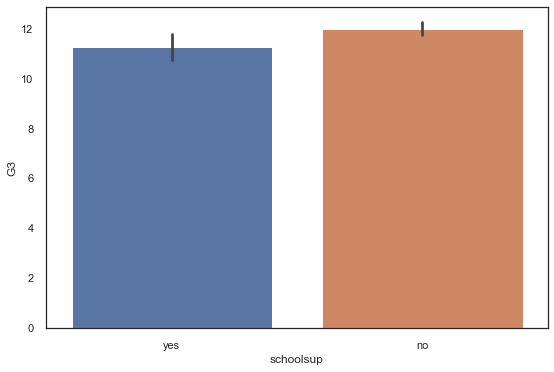

In [374]:
sns.barplot(x=p_orig.schoolsup, y=p.G3)

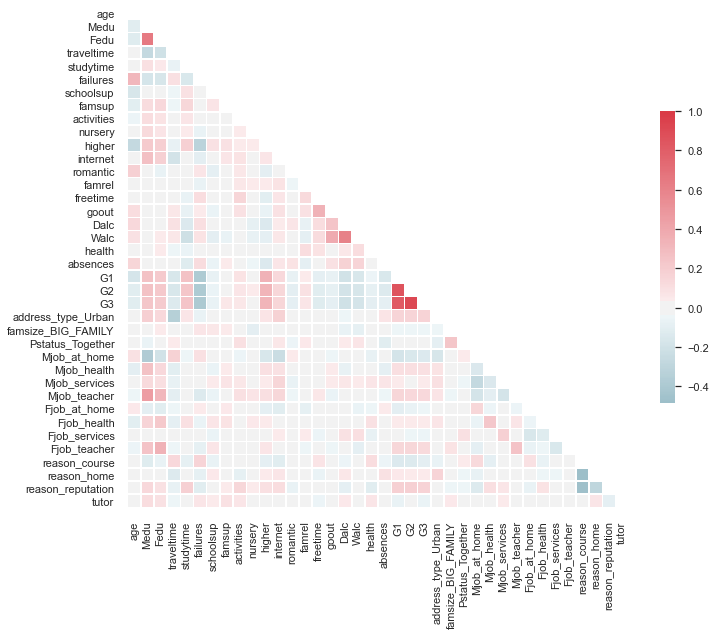

In [252]:
sns.set(style="white")

# Compute the correlation matrix
corr = p.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

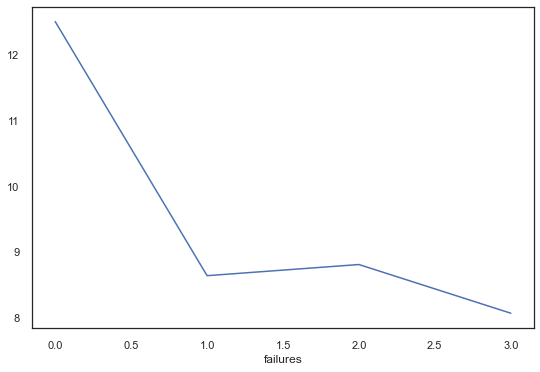

In [253]:
p.groupby('failures')['G3'].mean().plot()

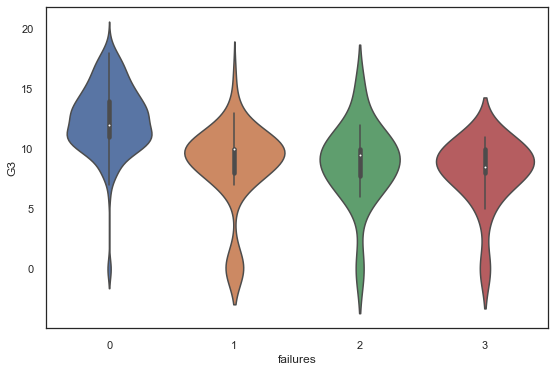

In [254]:
sns.violinplot(p.failures, p.G3)

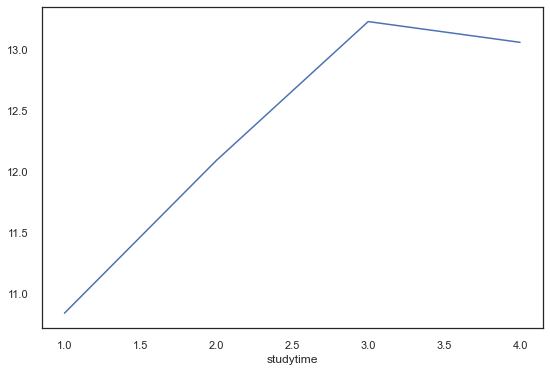

In [255]:
p.groupby('studytime')['G3'].mean().plot()

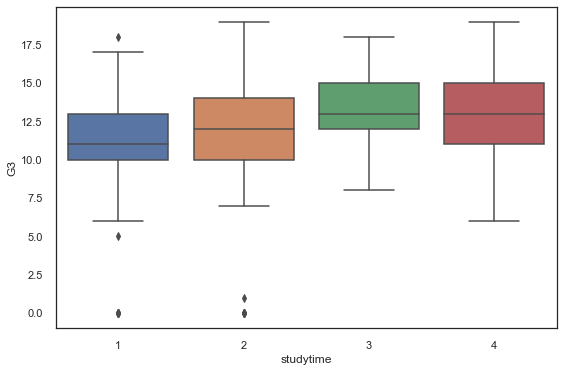

In [340]:
sns.boxplot(p.studytime, p.G3)

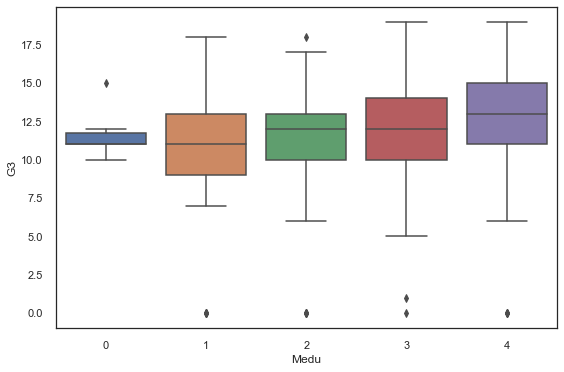

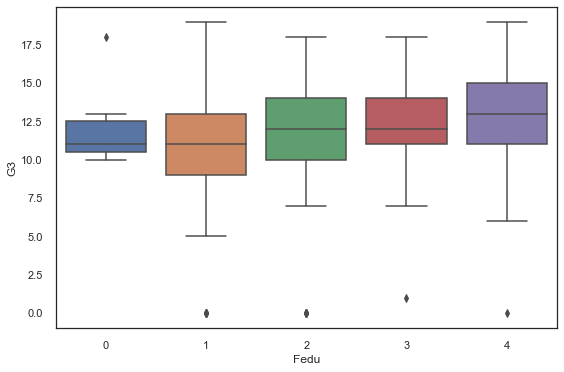

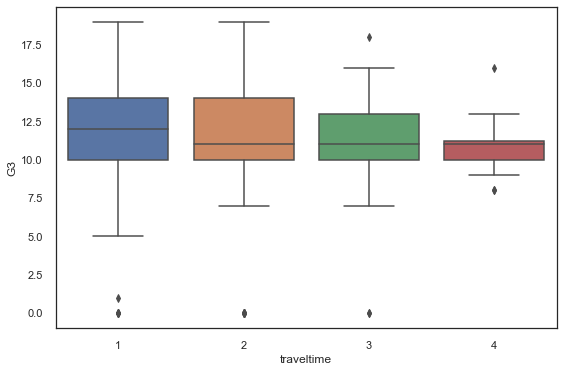

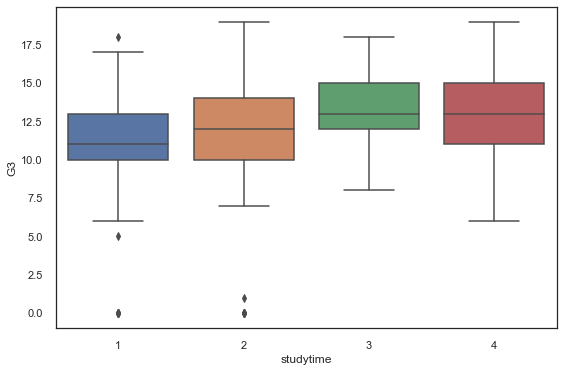

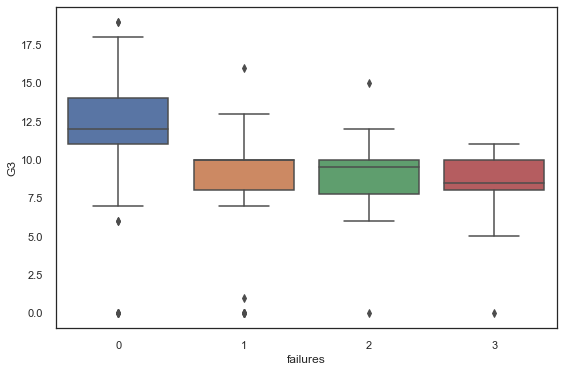

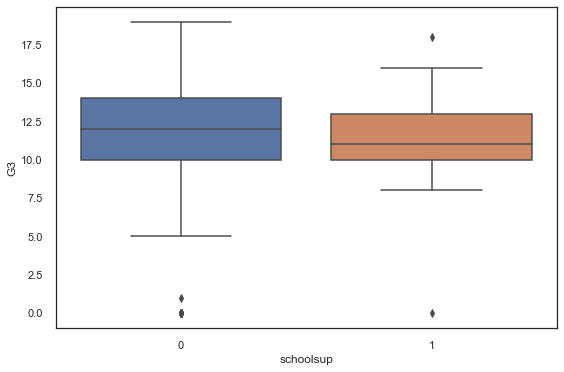

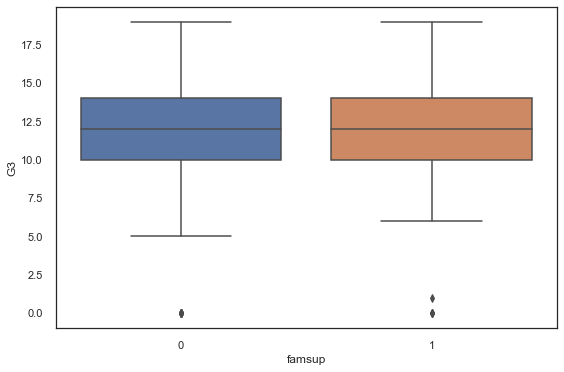

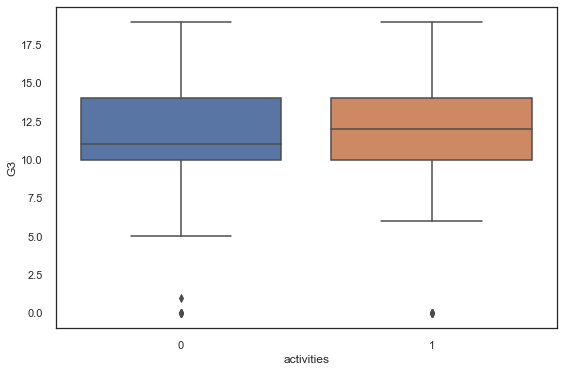

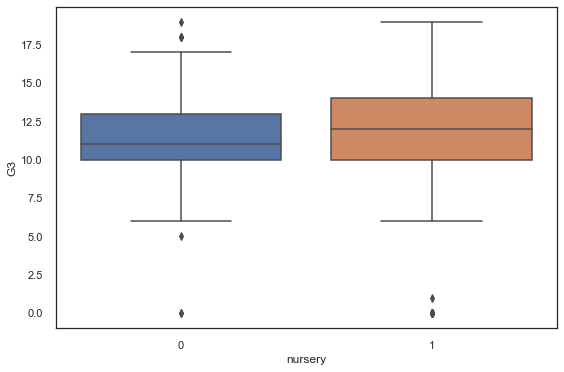

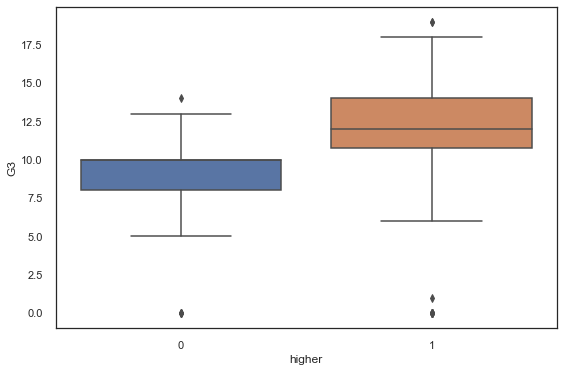

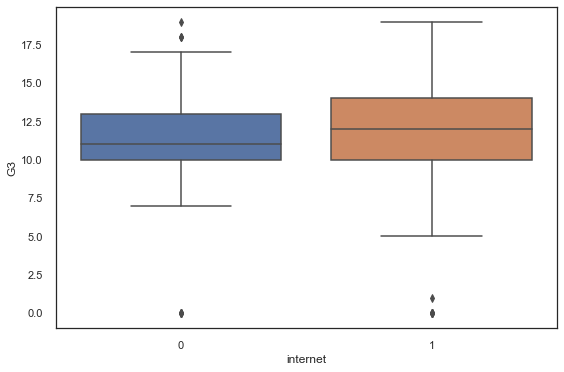

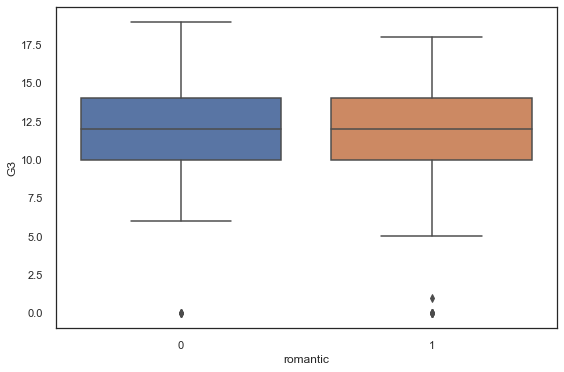

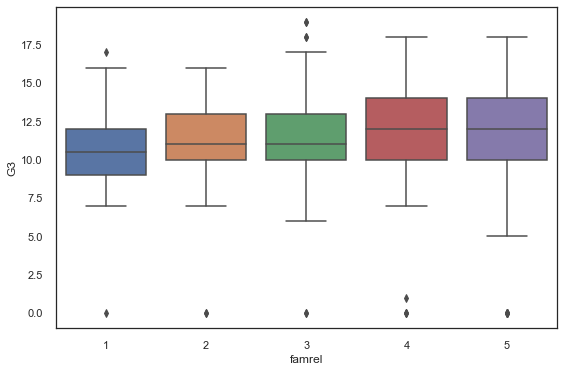

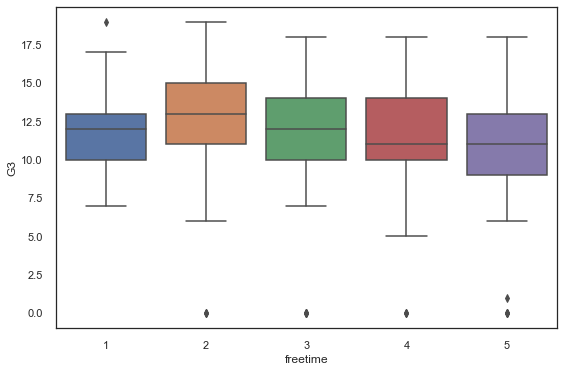

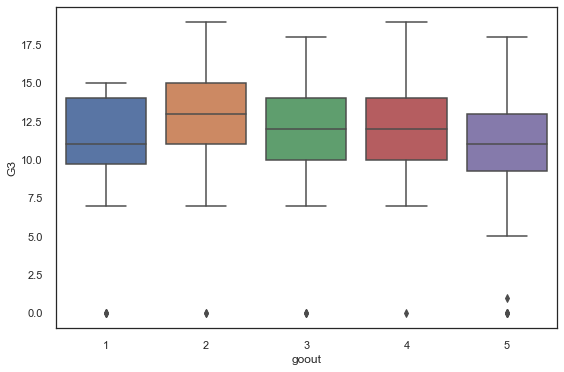

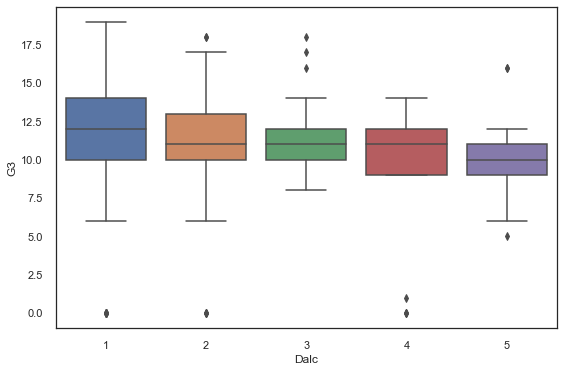

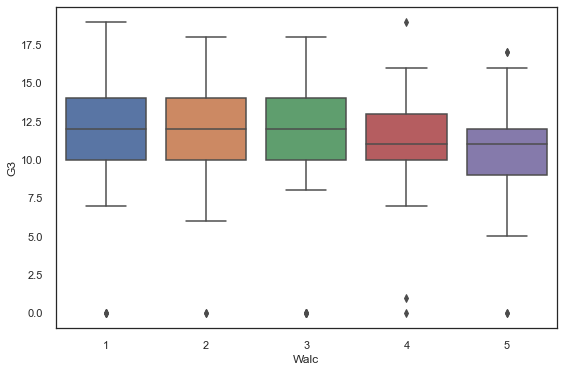

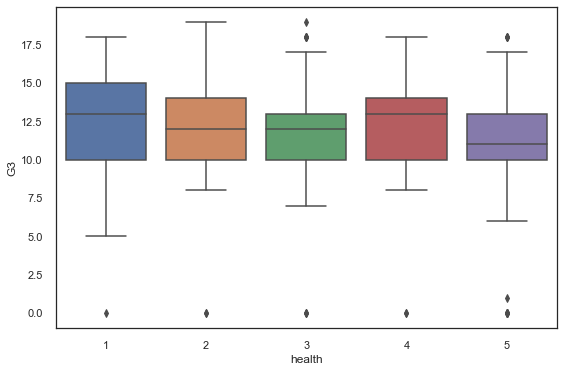

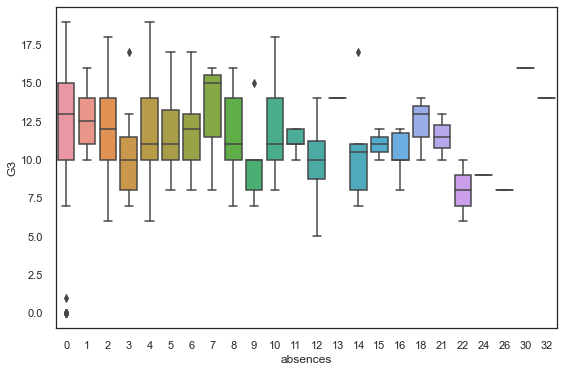

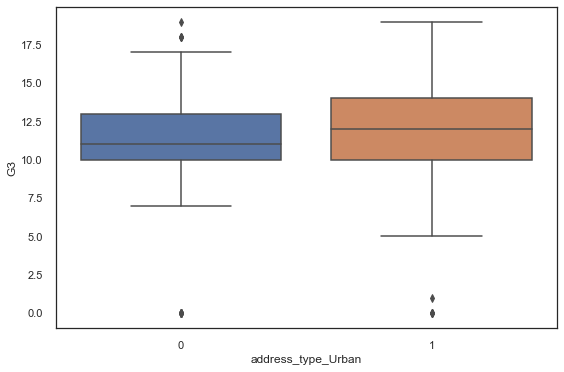

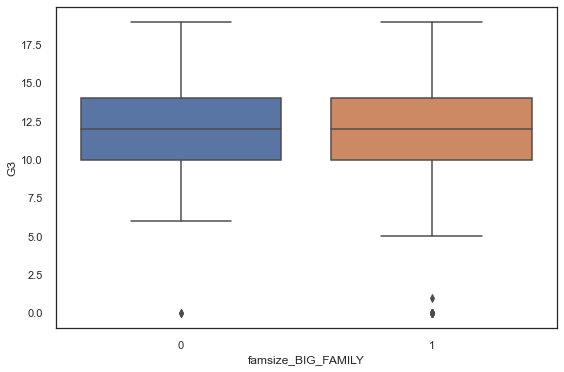

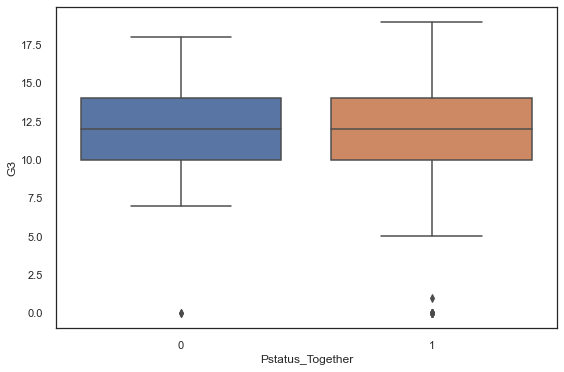

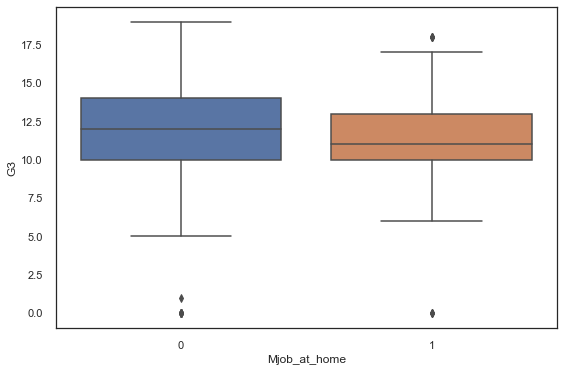

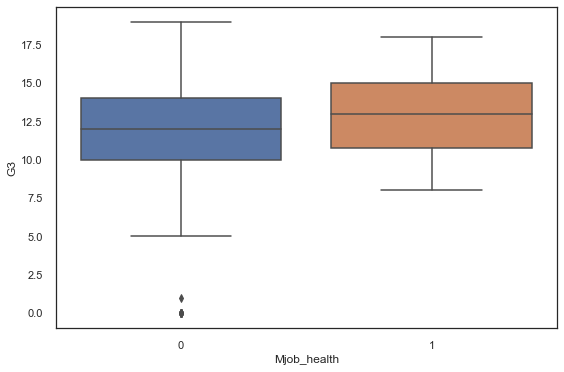

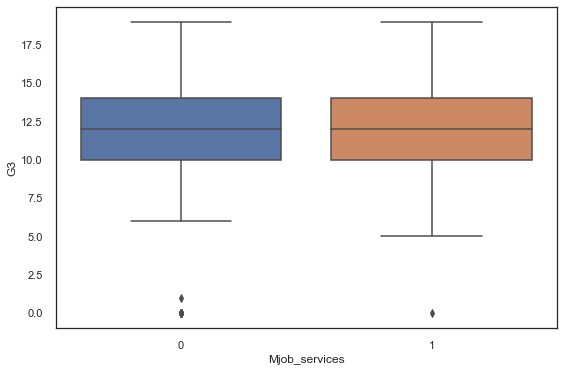

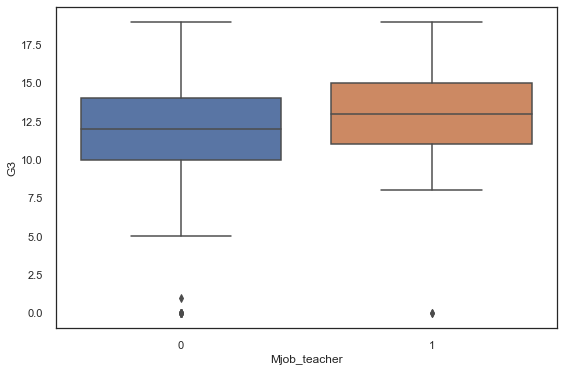

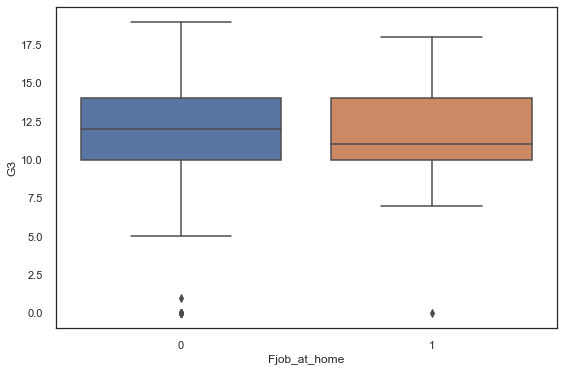

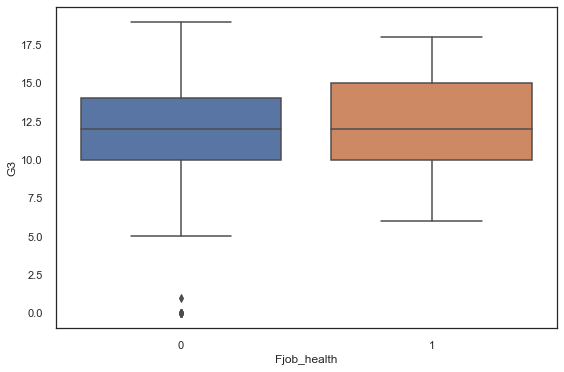

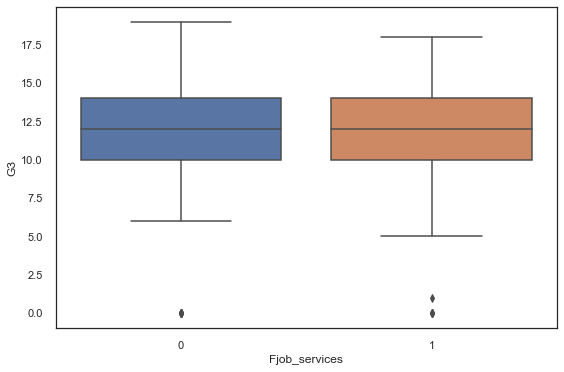

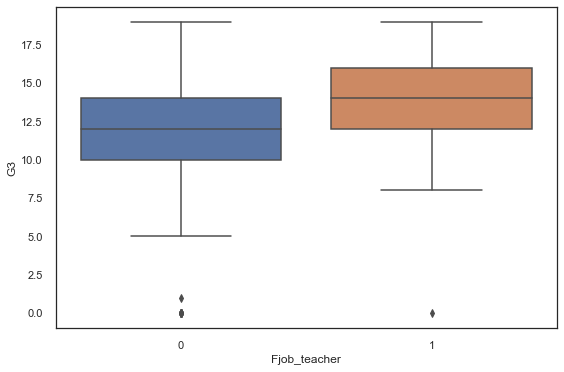

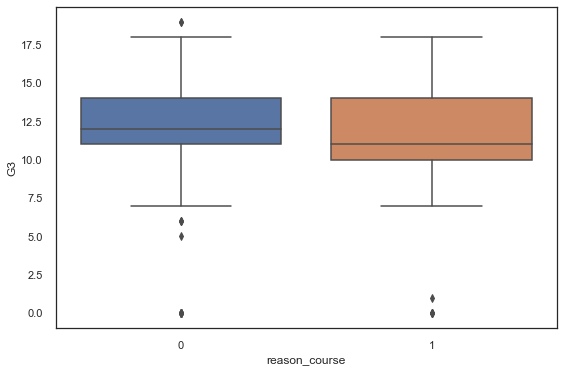

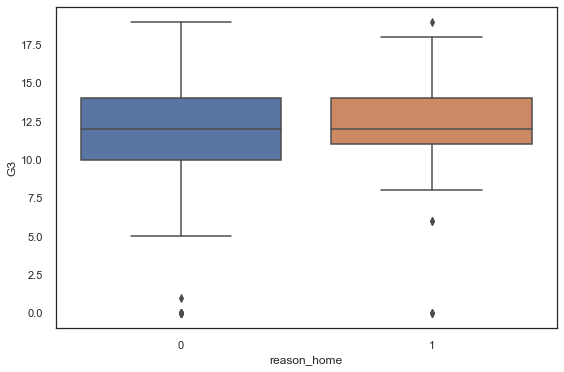

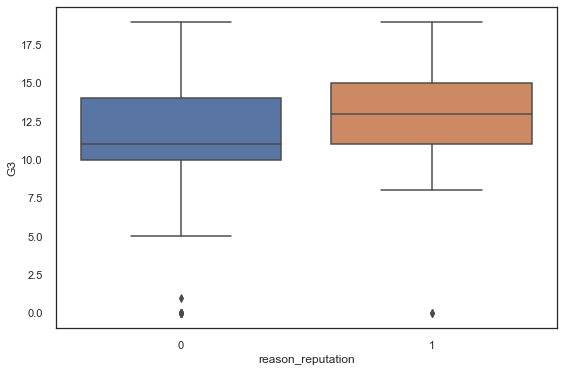

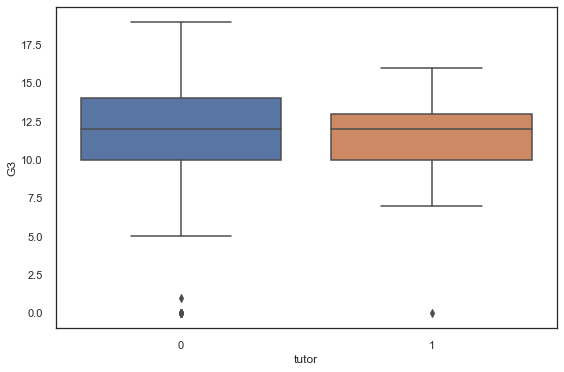

In [128]:
for i in p_feature:
    x = p_feature[i]
    sns.boxplot(x=x, y=p.G3)
    plt.show()

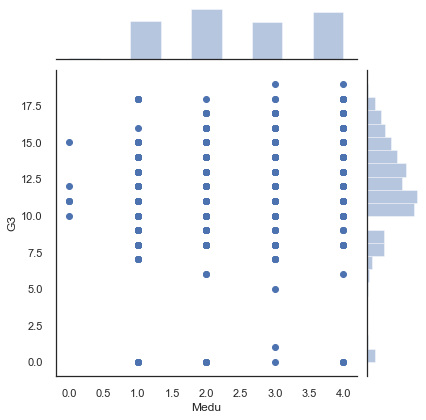

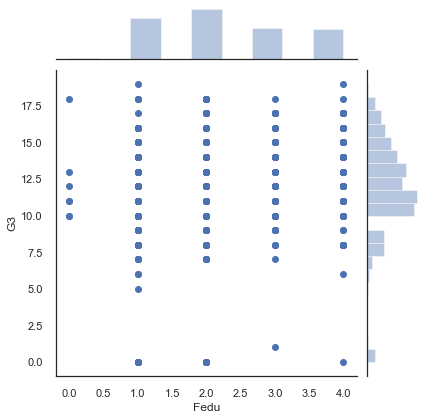

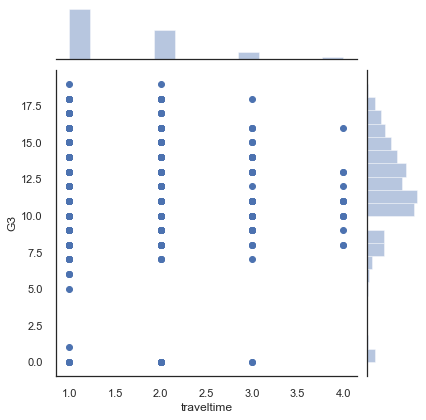

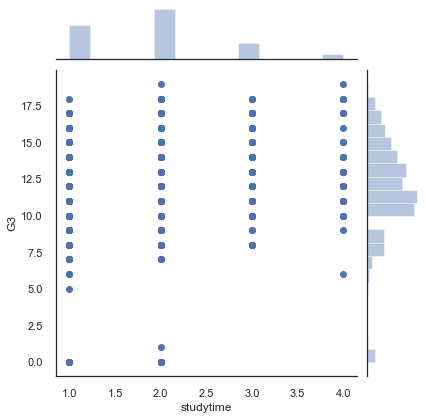

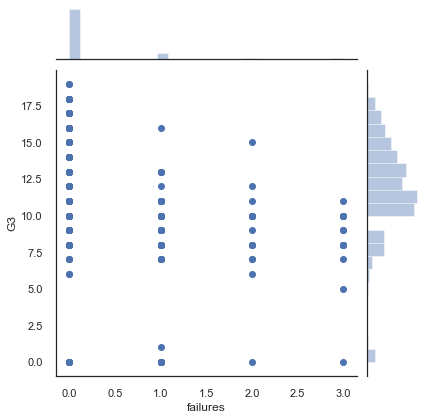

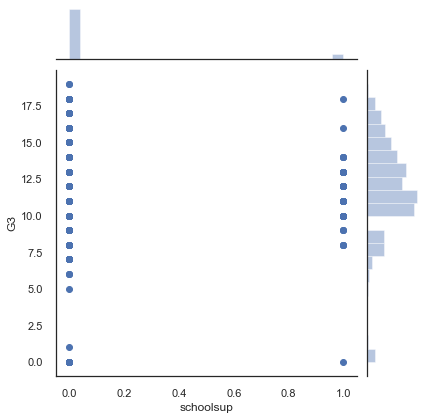

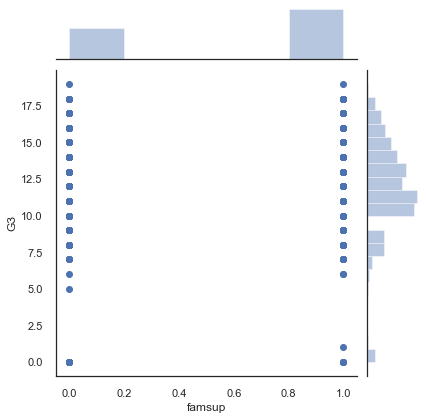

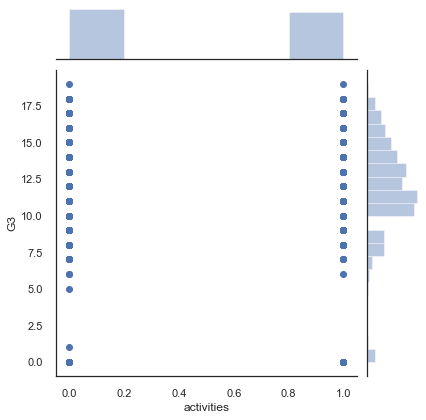

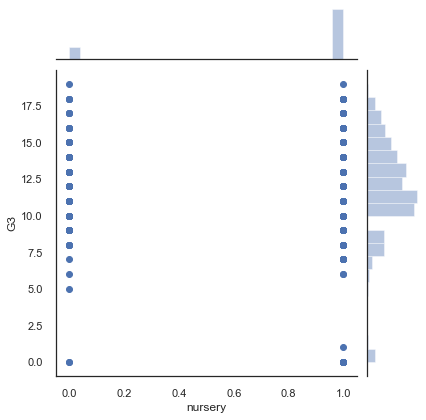

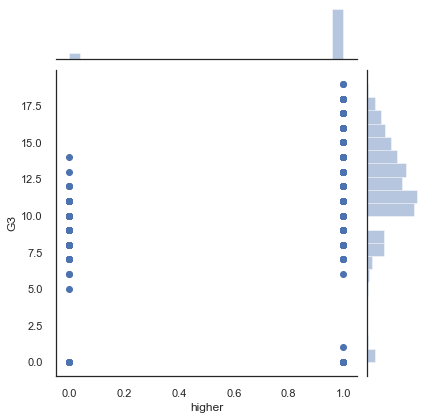

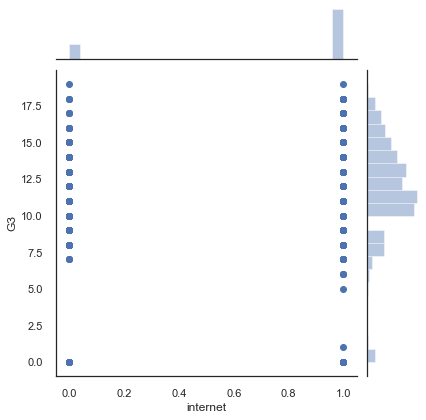

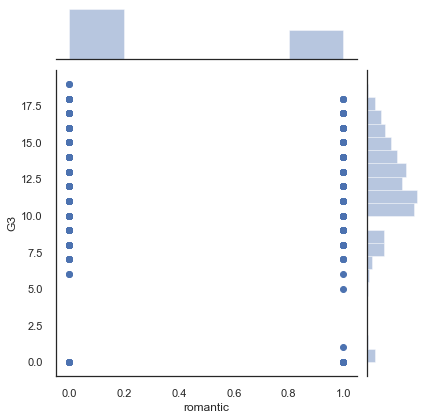

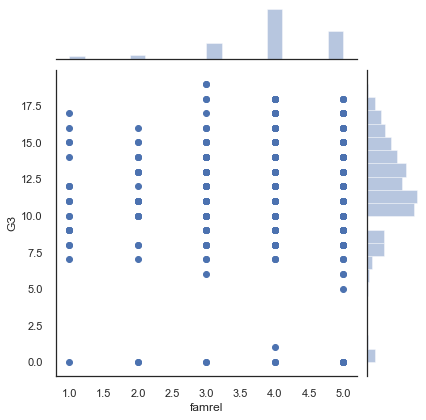

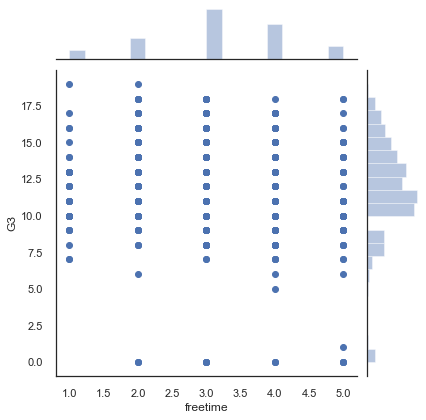

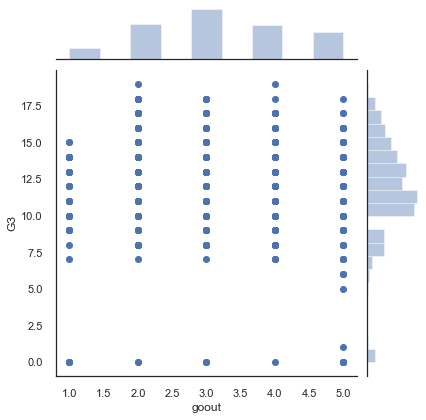

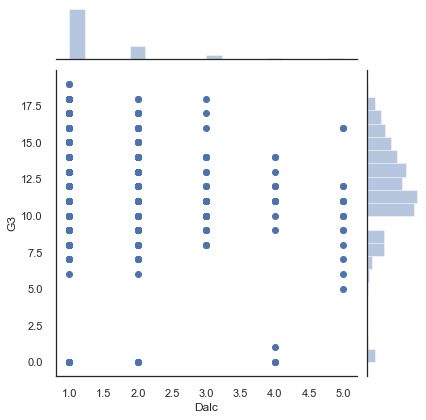

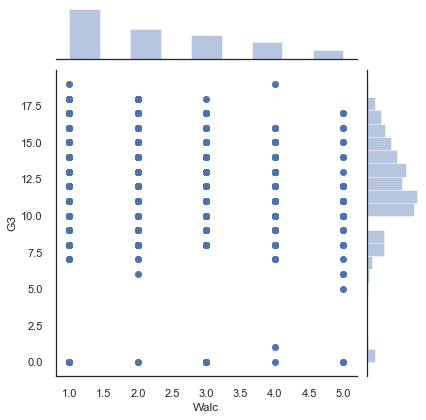

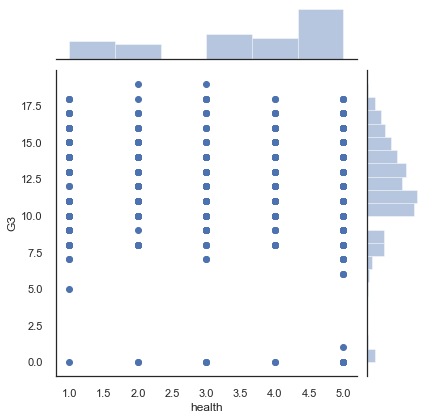

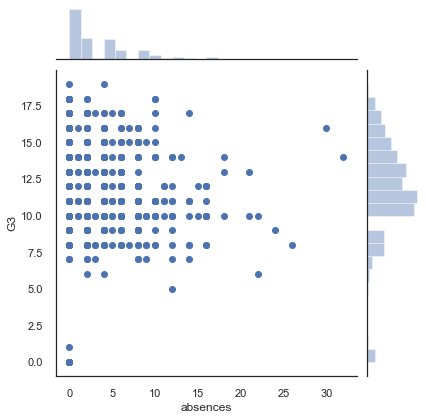

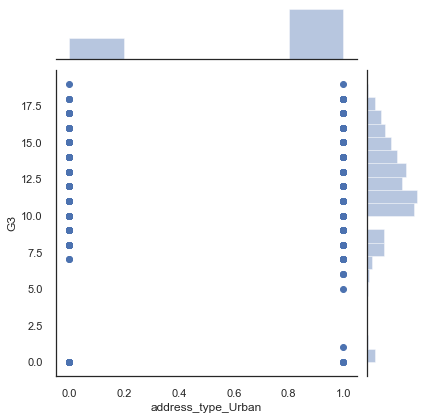

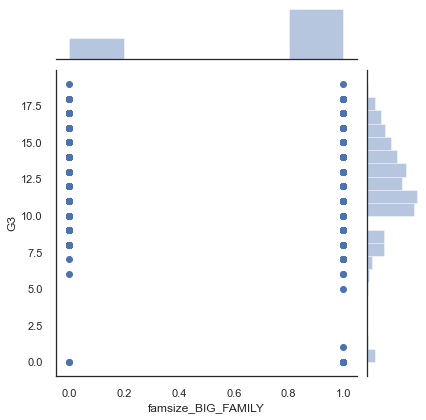

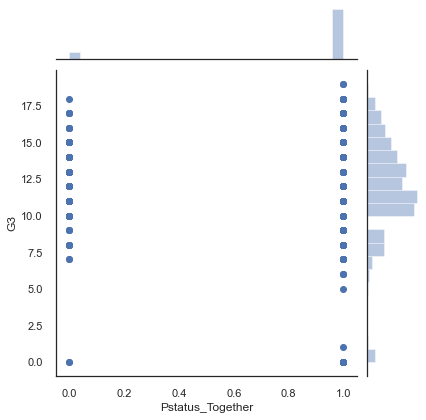

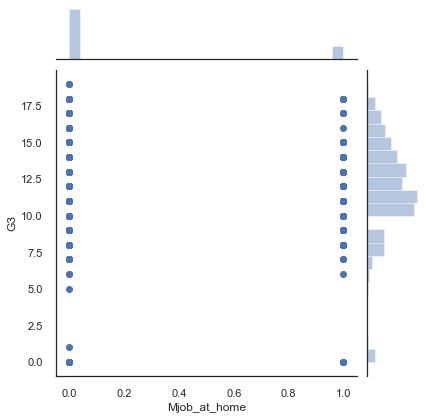

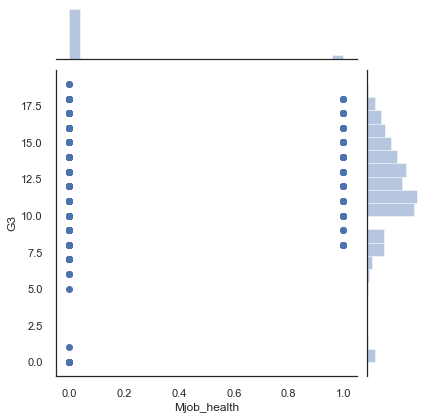

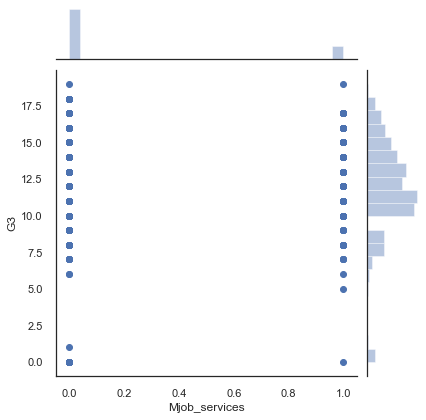

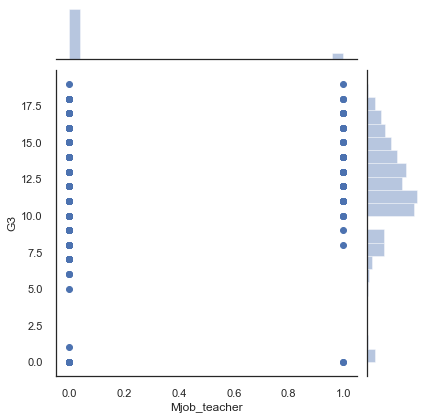

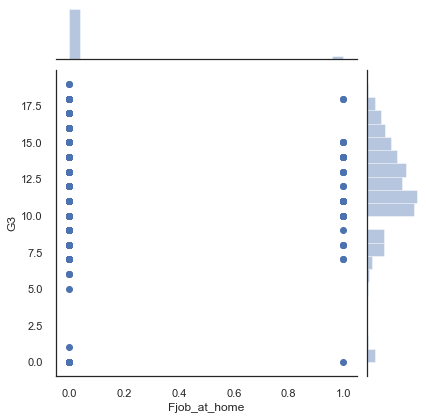

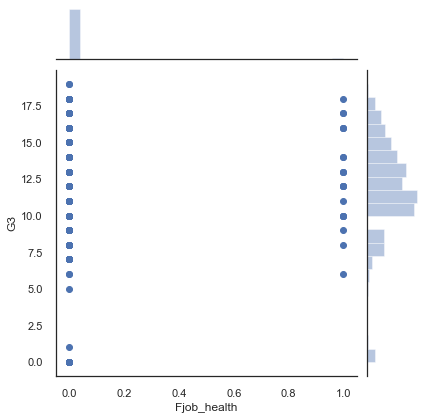

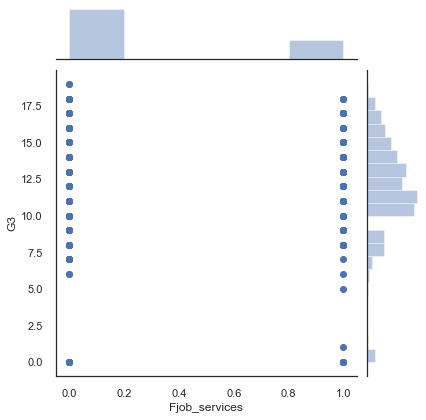

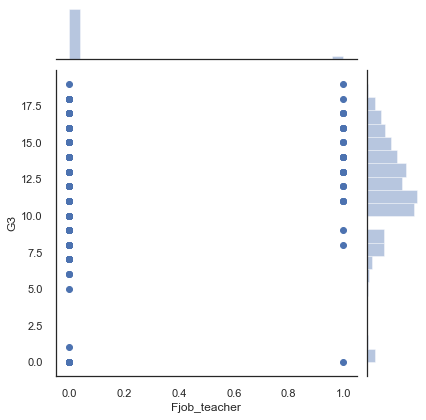

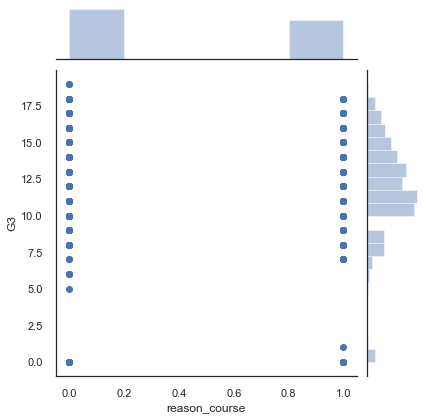

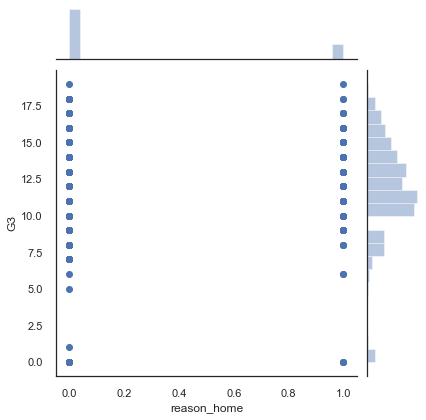

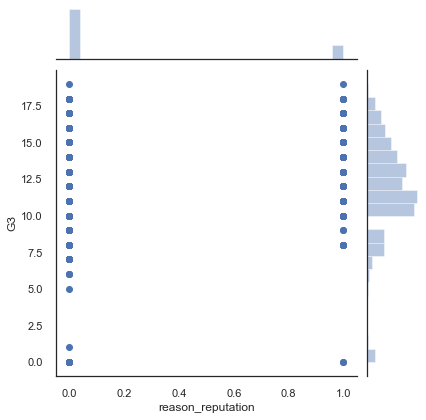

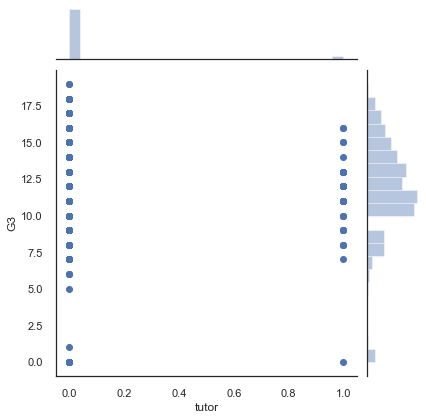

In [129]:
for i in p_feature:
    x = p_feature[i]
    sns.jointplot(x=x, y=p.G3)
    plt.show()

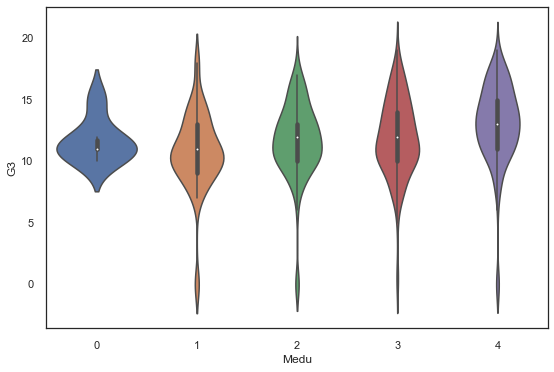

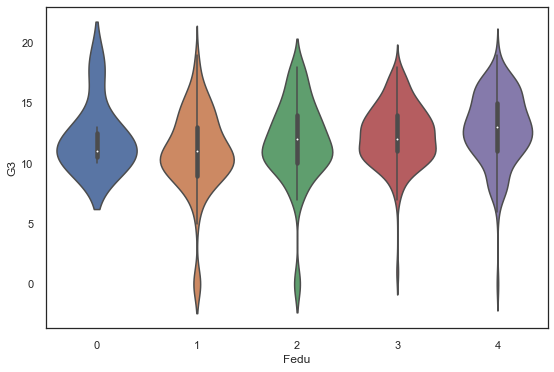

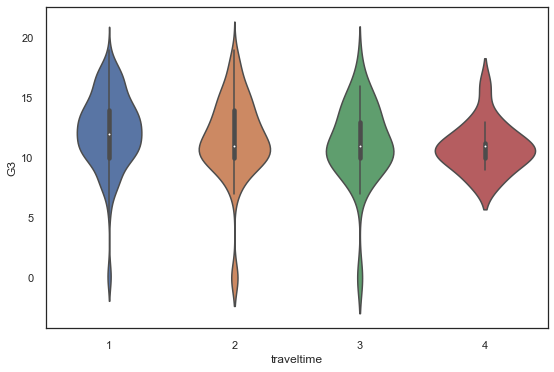

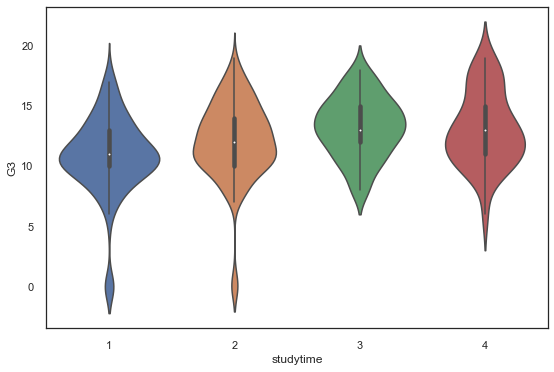

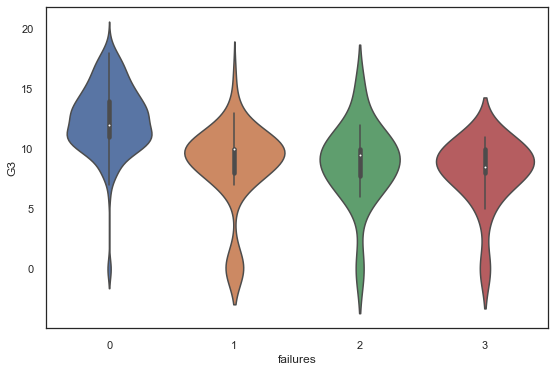

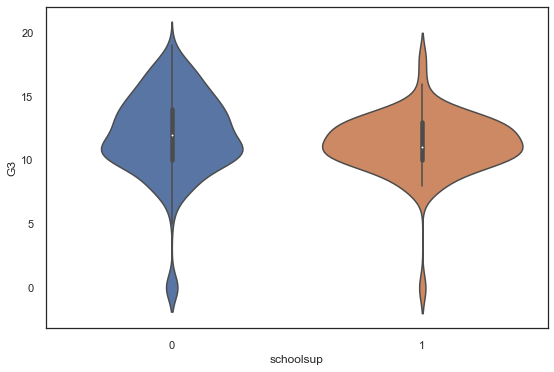

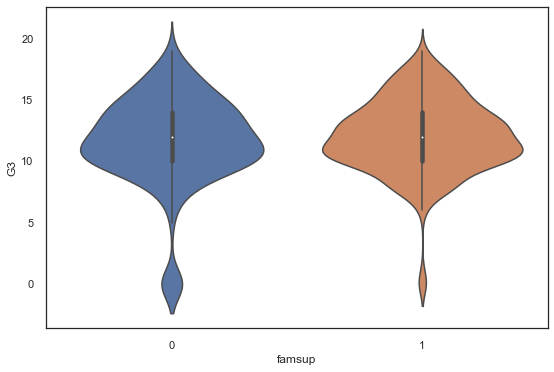

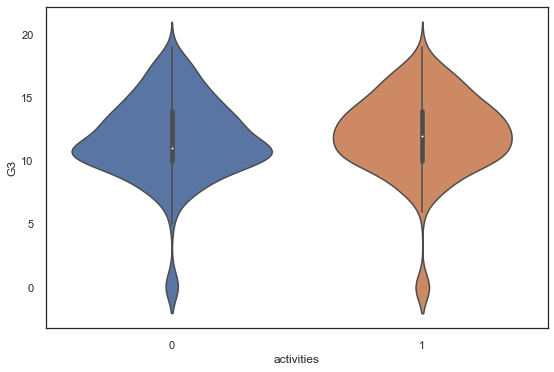

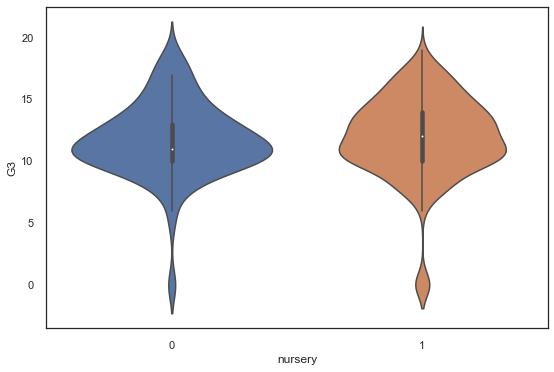

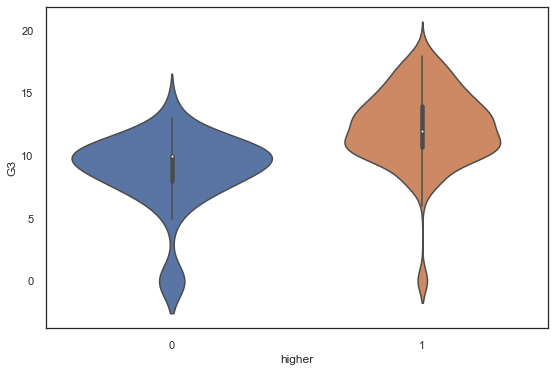

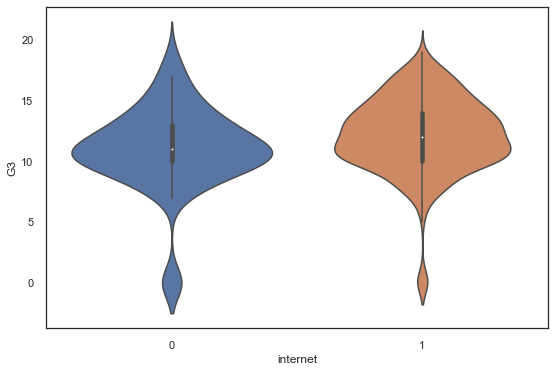

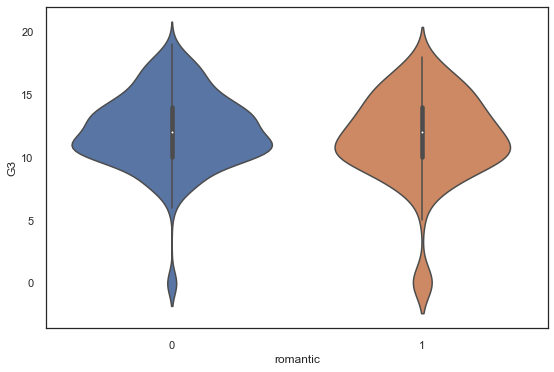

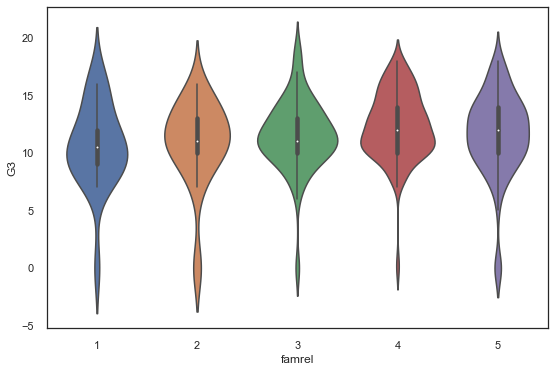

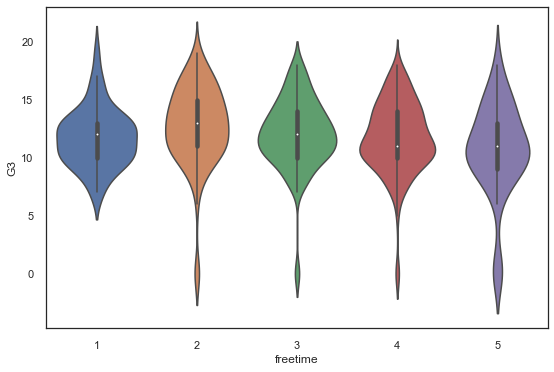

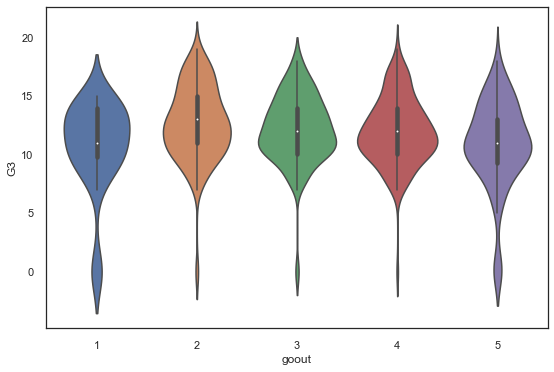

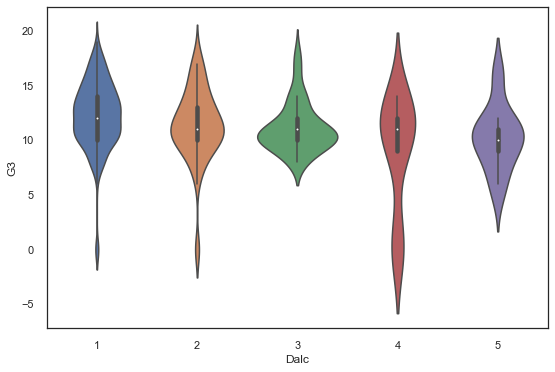

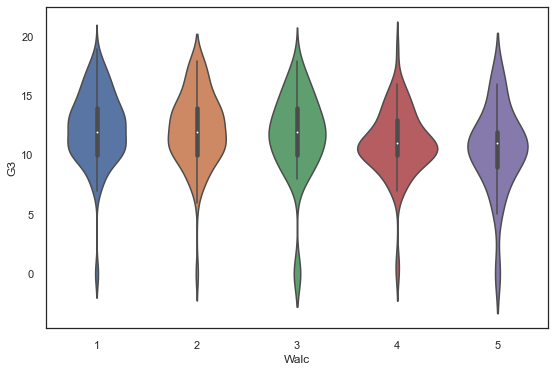

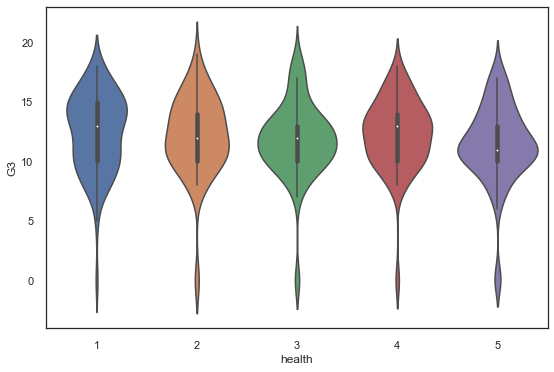

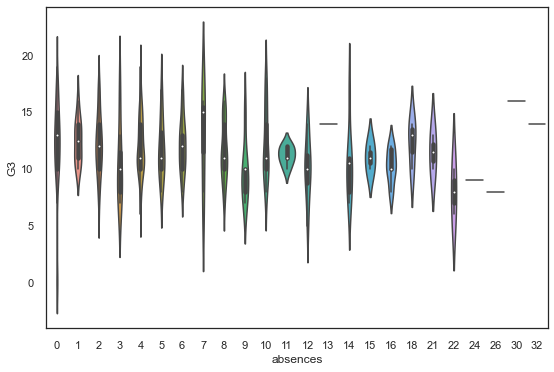

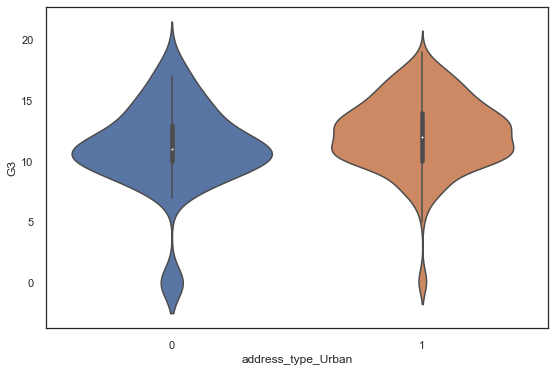

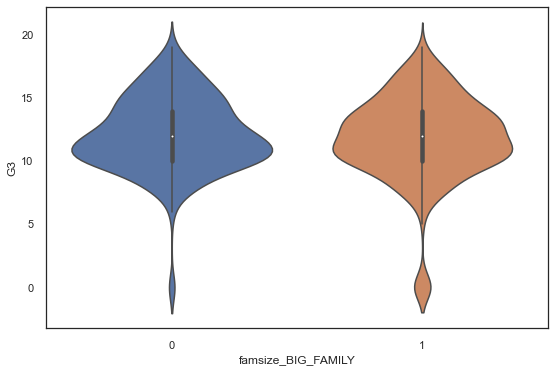

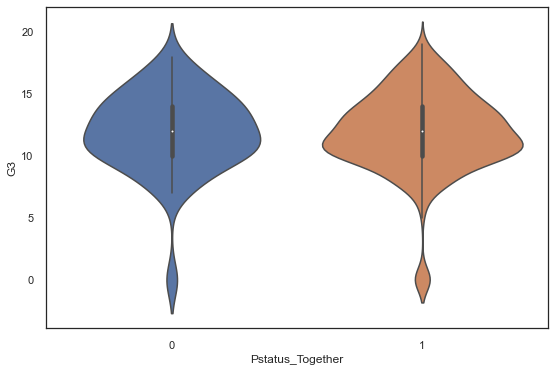

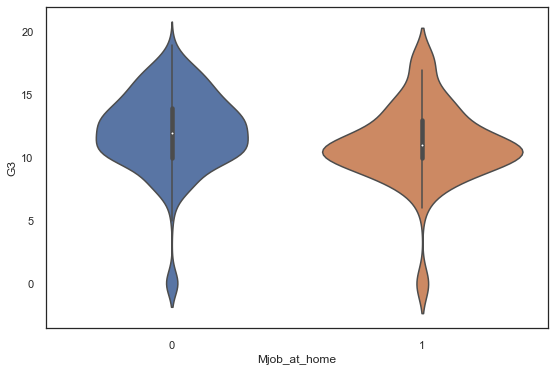

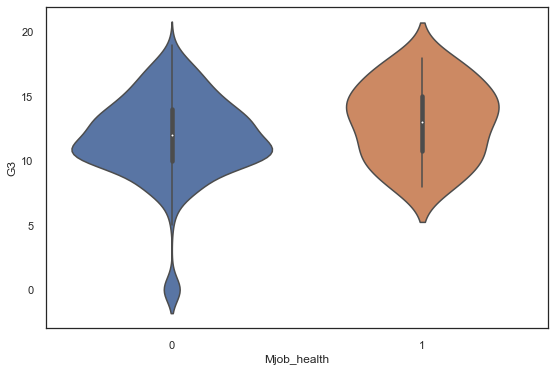

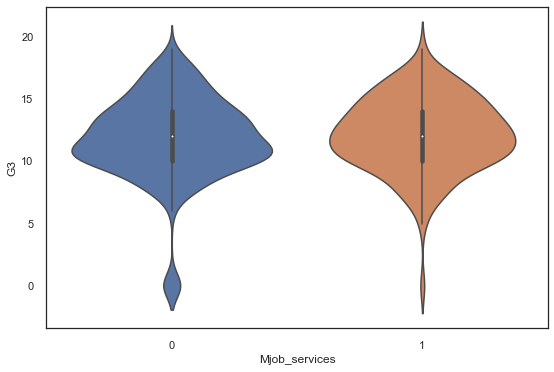

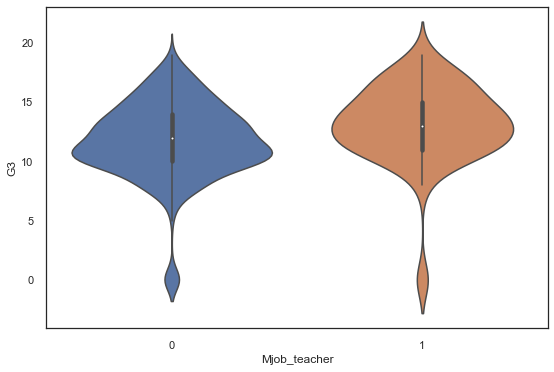

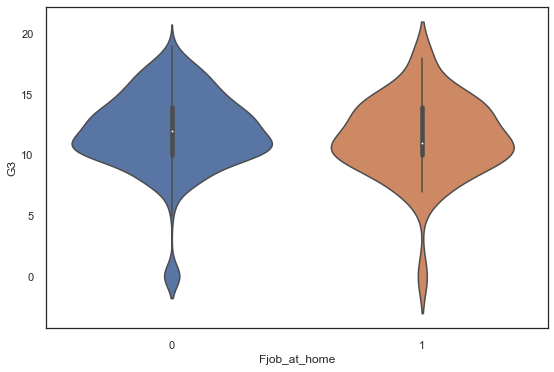

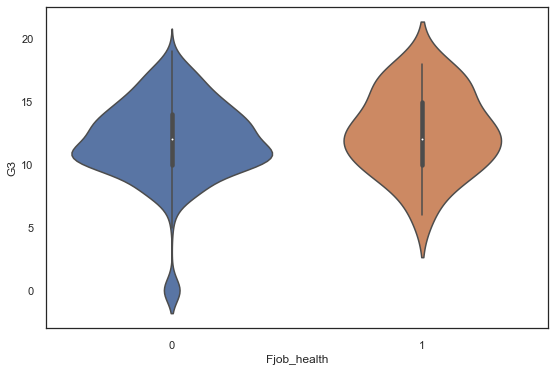

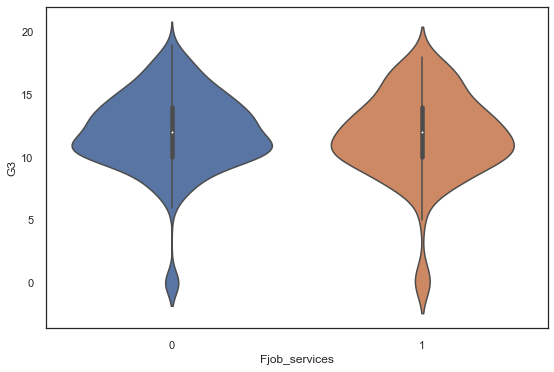

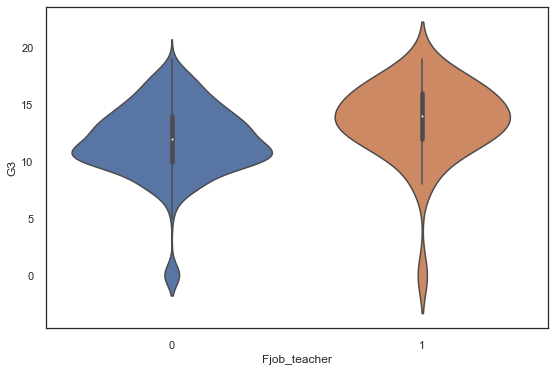

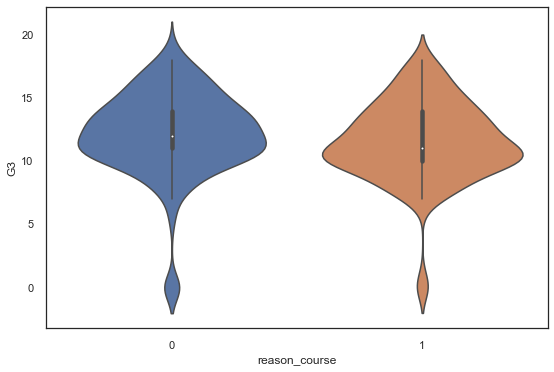

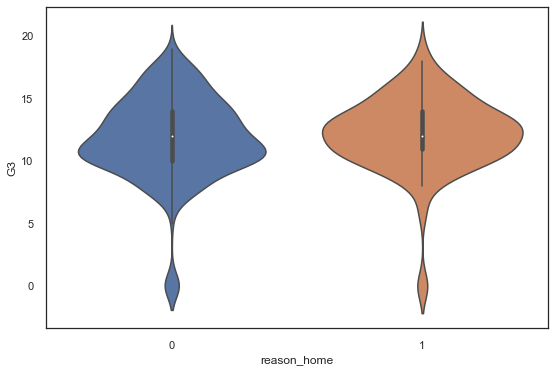

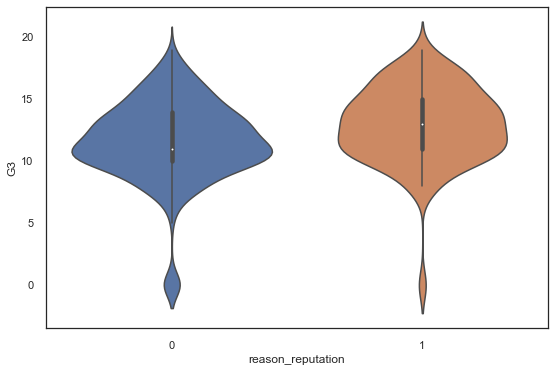

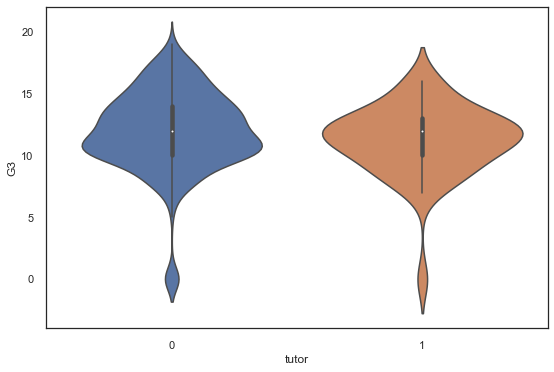

In [130]:
for i in p_feature:
    x = p_feature[i]
    sns.violinplot(x=x, y=p.G3)
    plt.show()

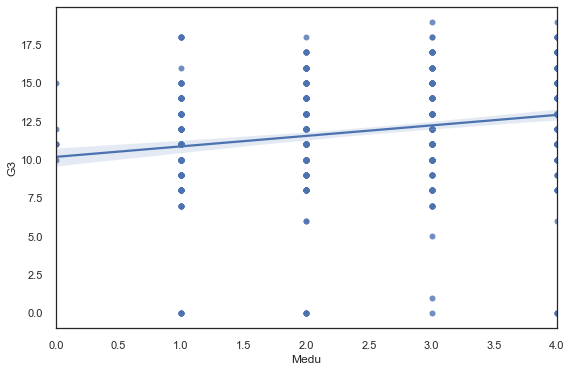

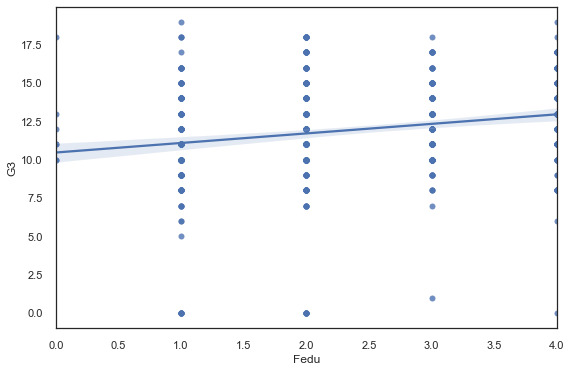

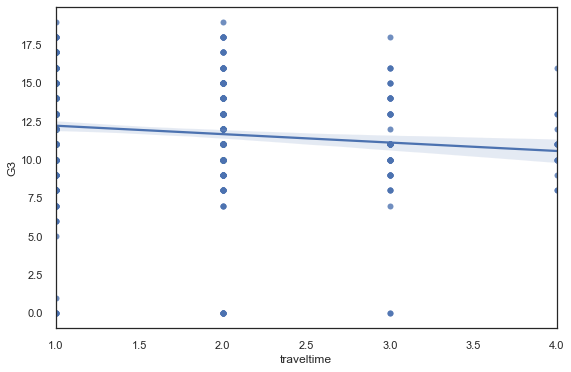

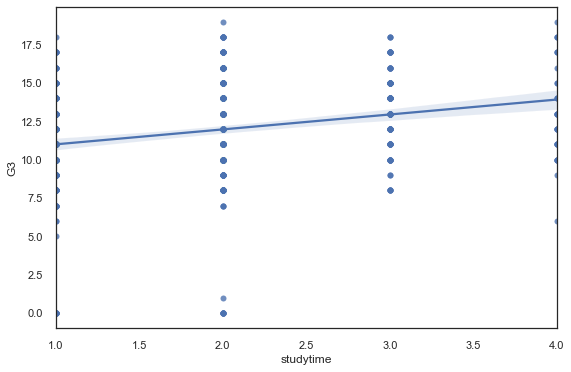

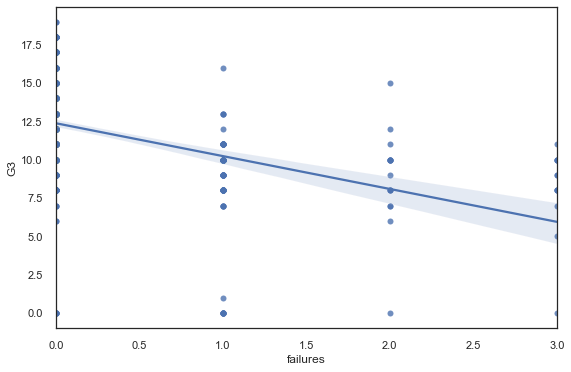

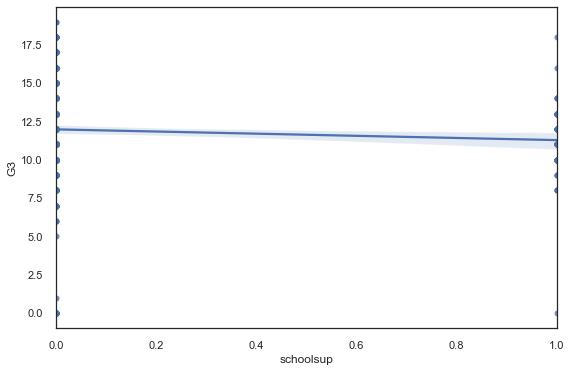

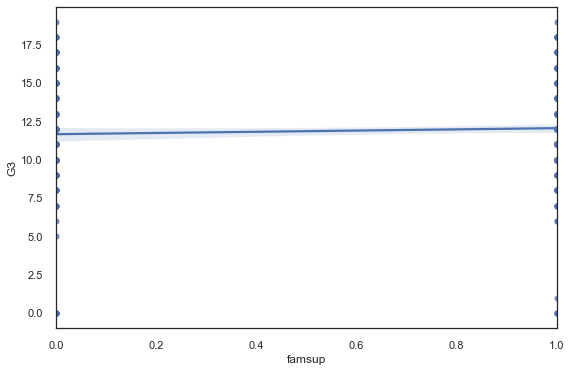

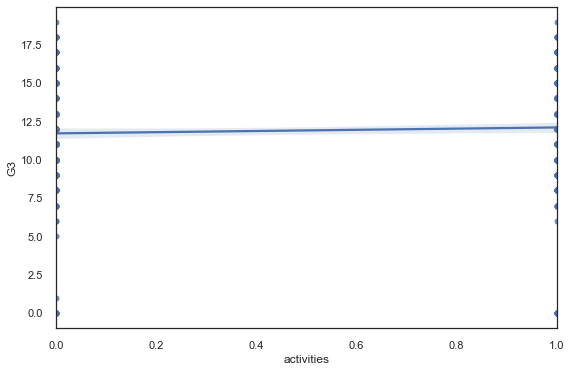

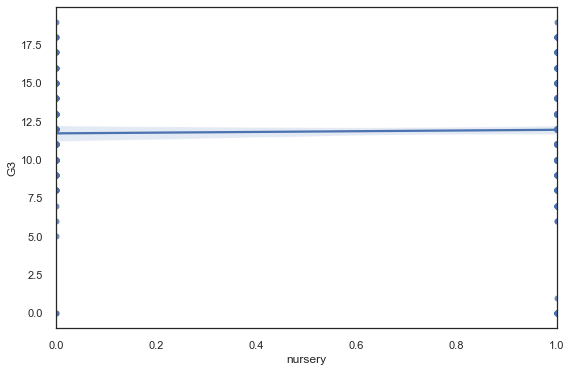

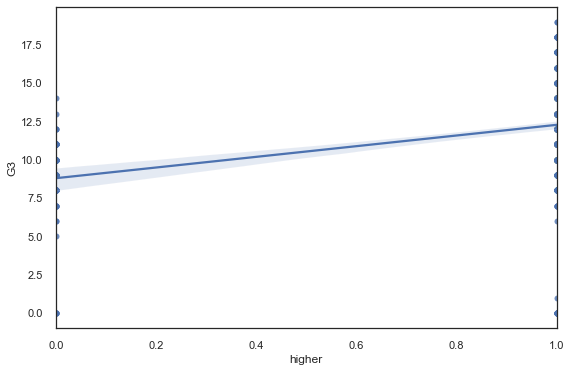

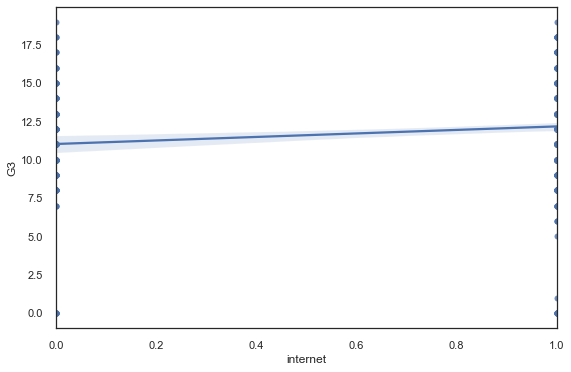

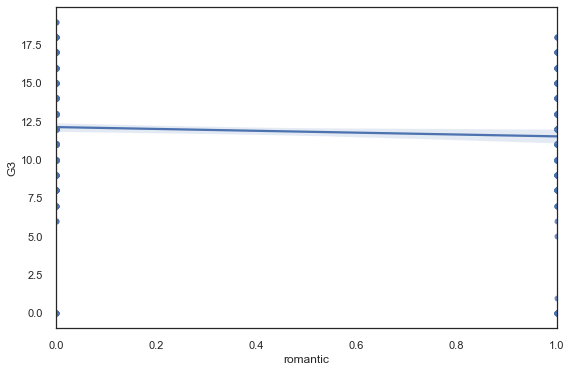

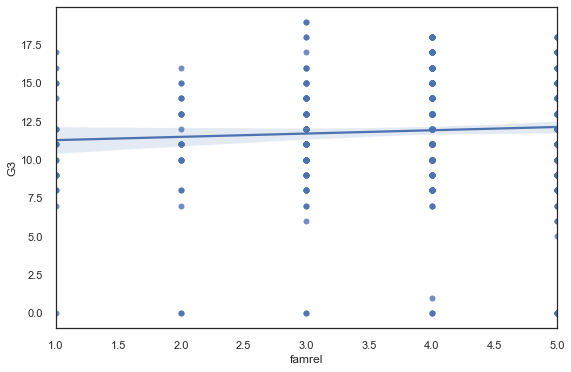

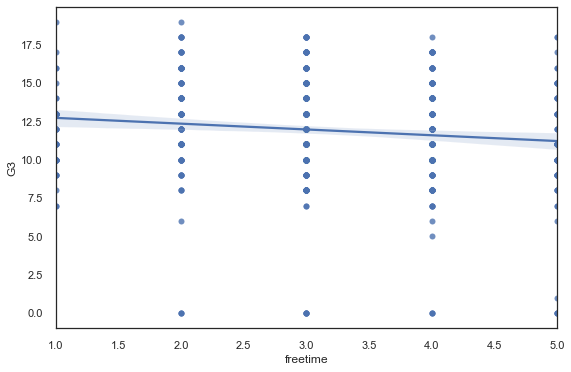

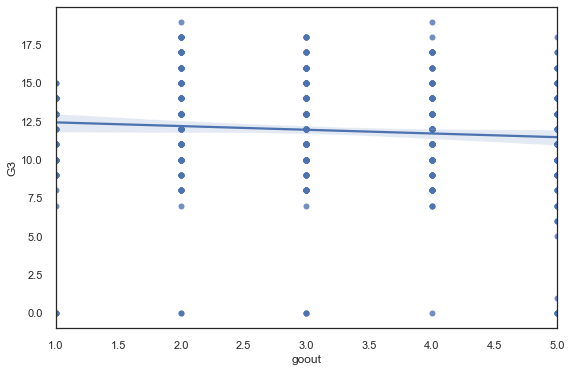

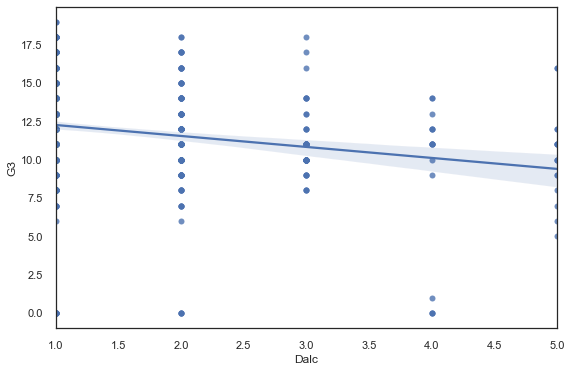

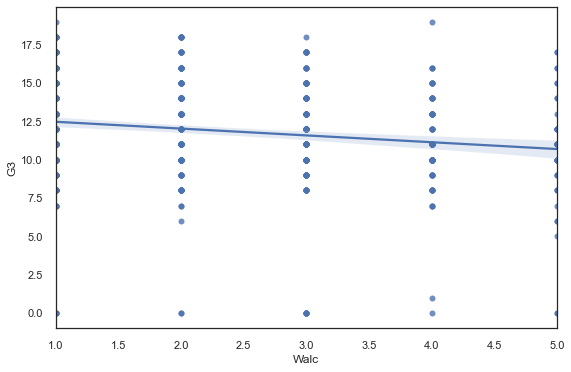

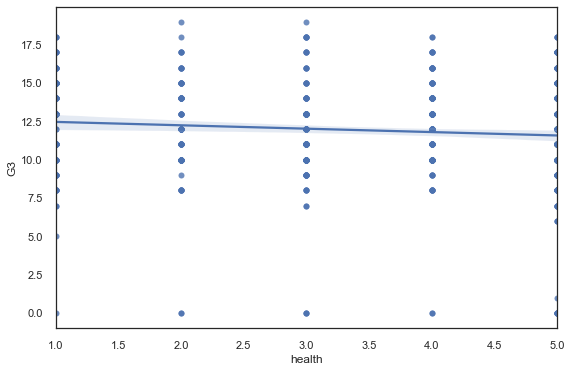

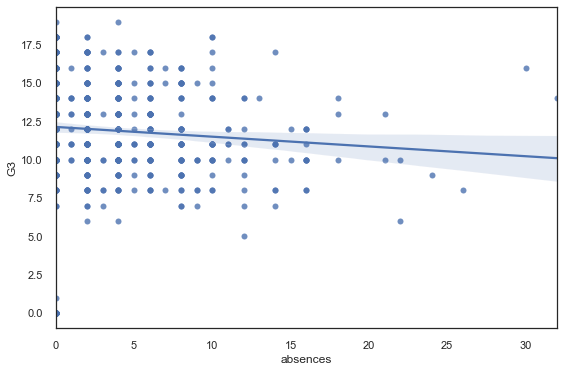

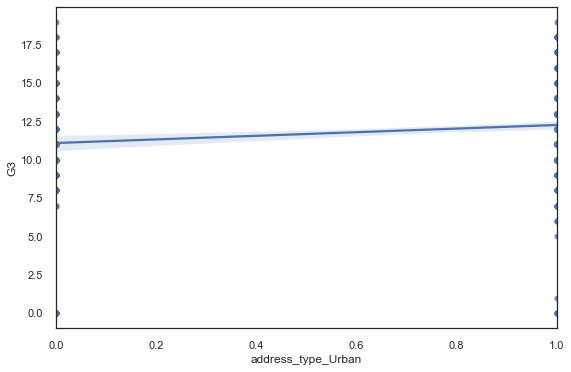

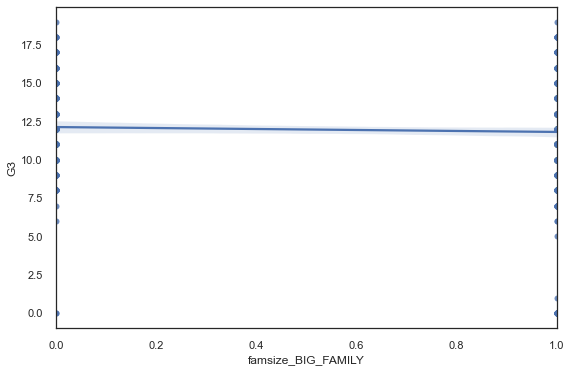

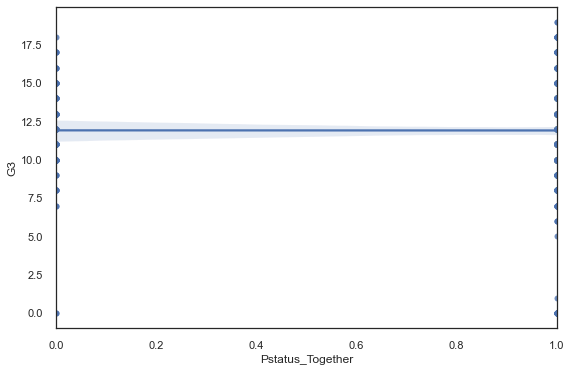

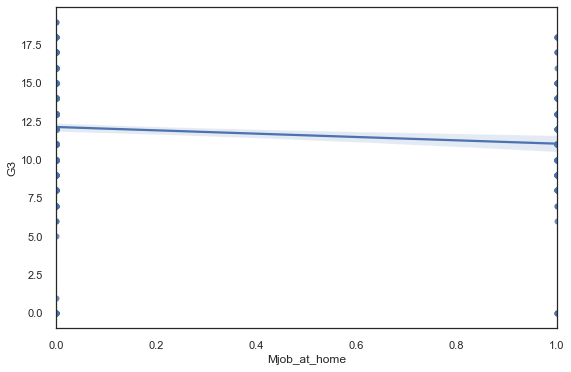

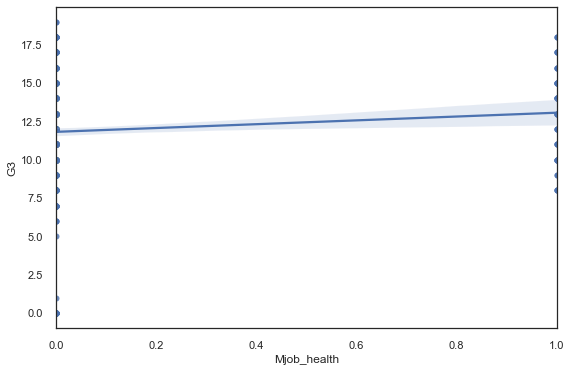

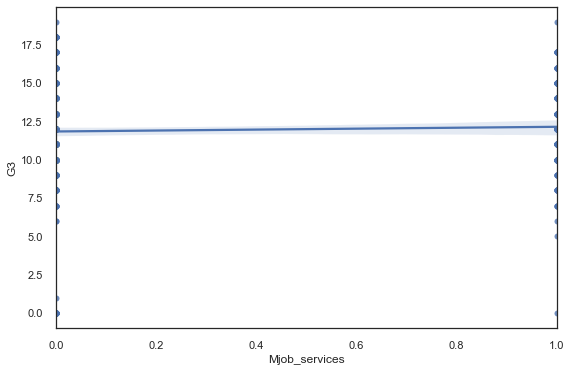

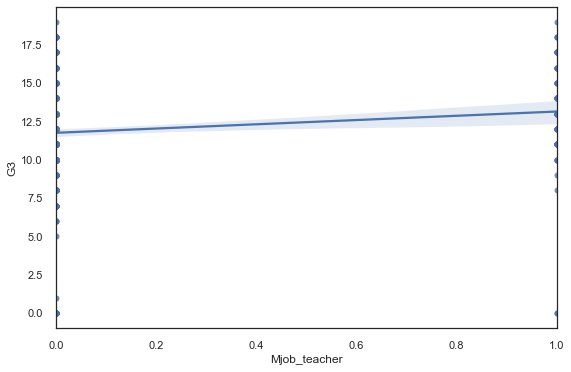

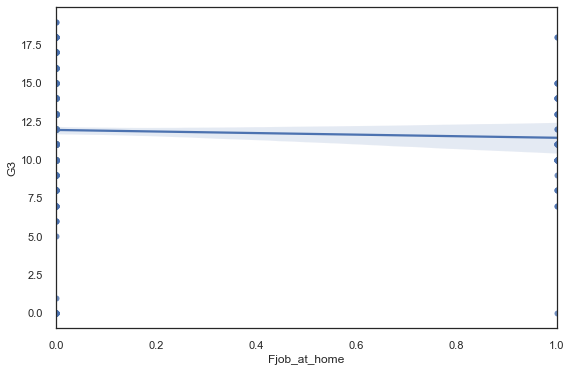

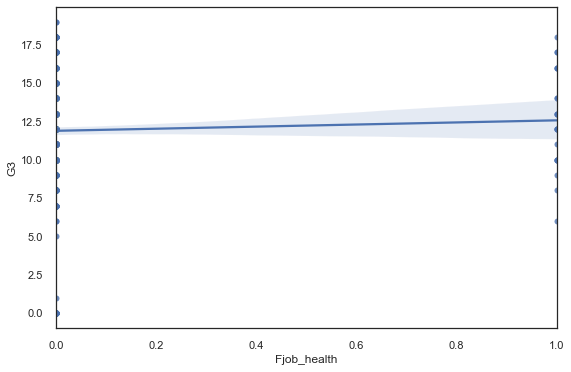

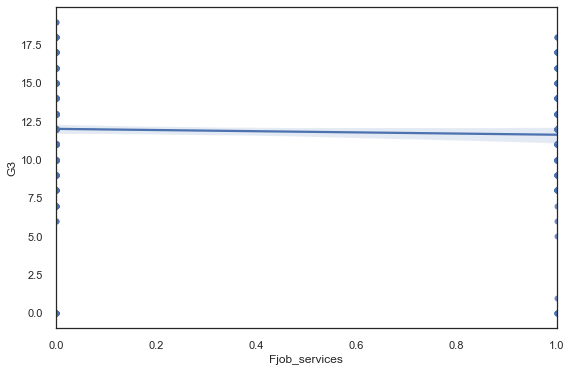

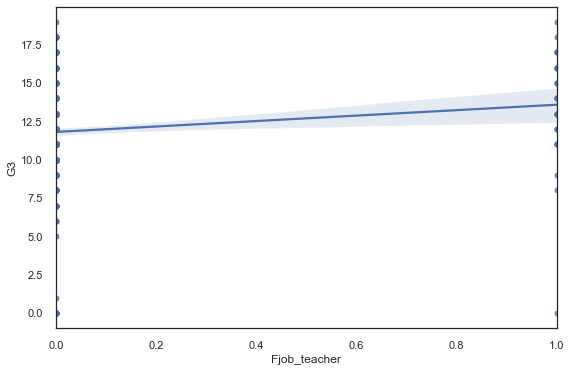

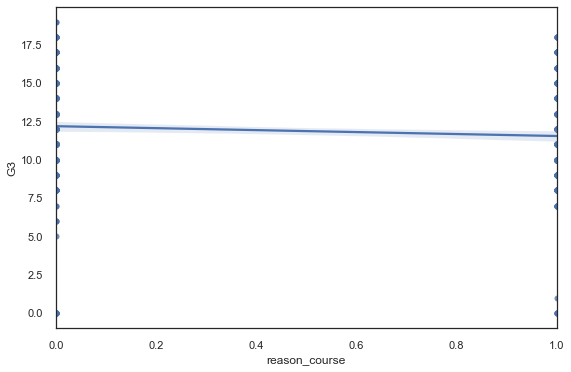

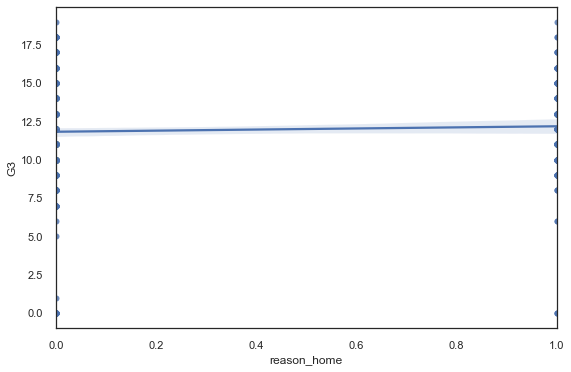

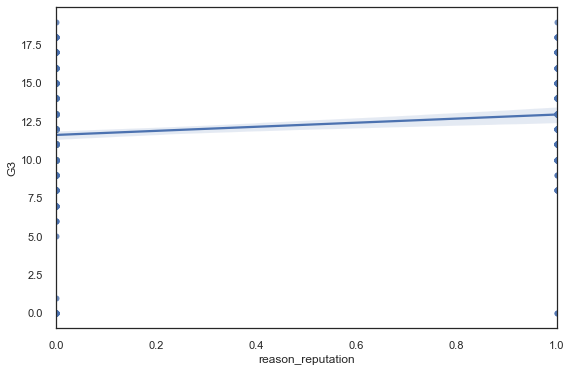

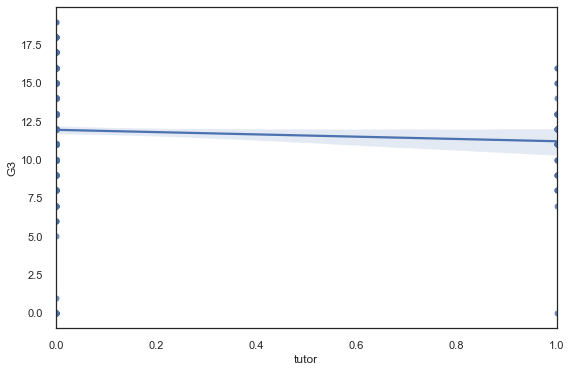

In [131]:
for i in p_feature:
    x = p_feature[i]
    sns.regplot(x=x, y=p.G3)
    plt.show()

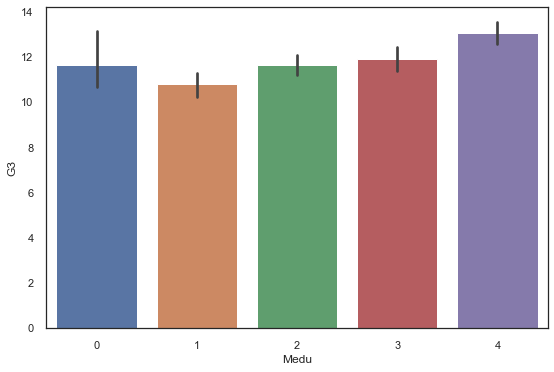

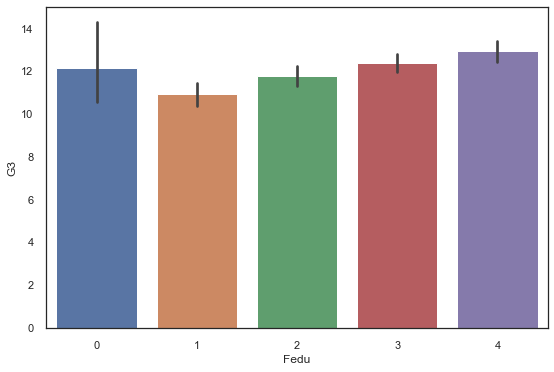

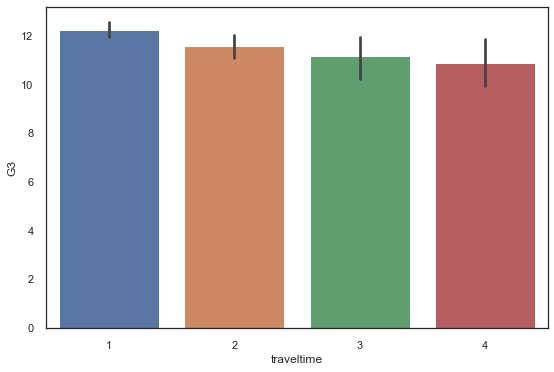

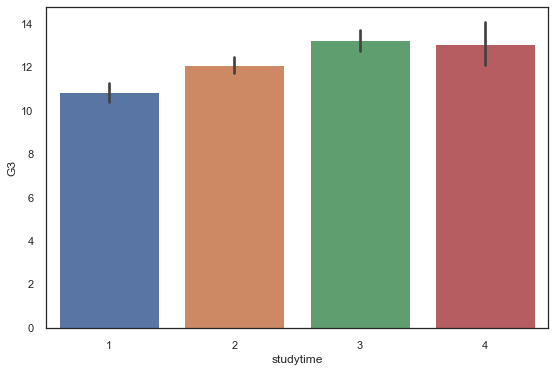

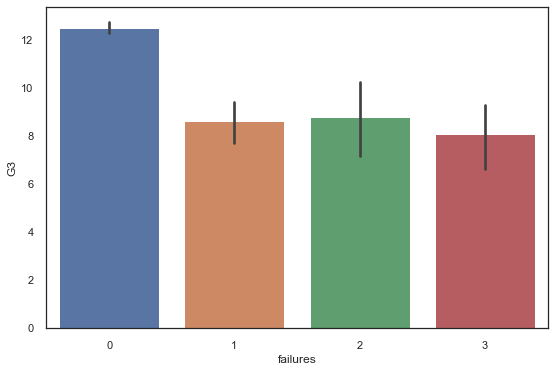

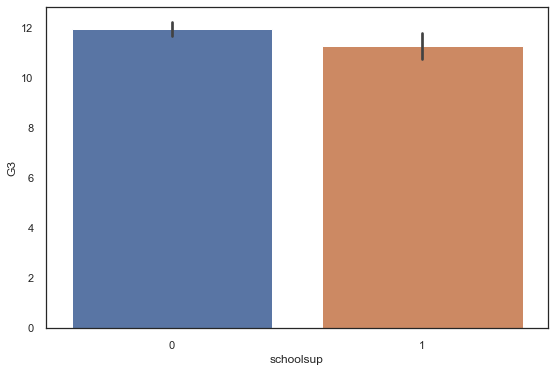

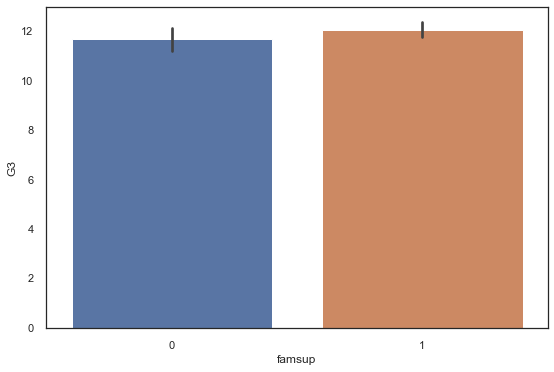

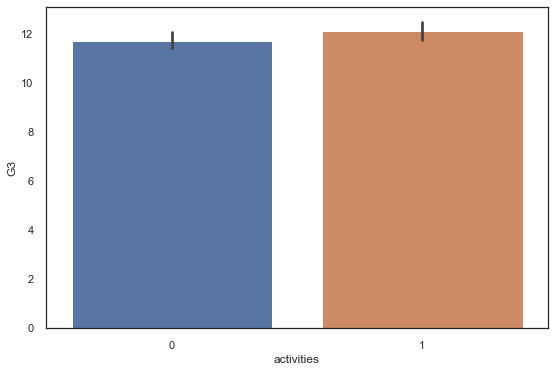

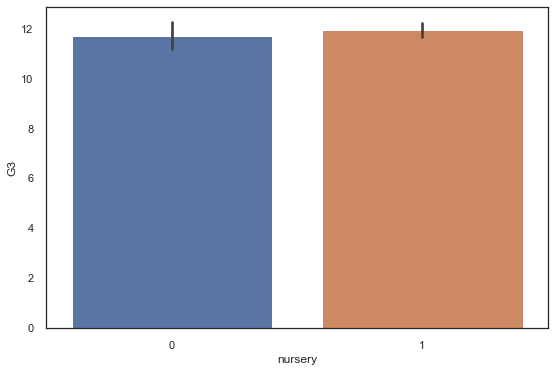

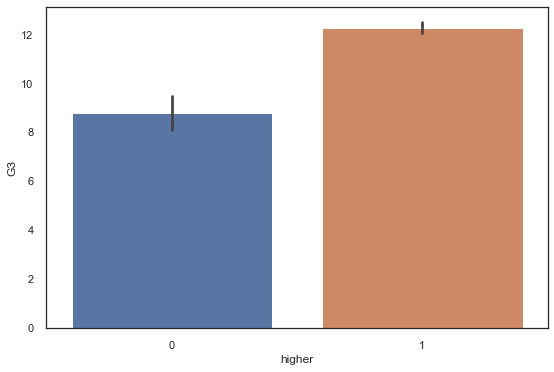

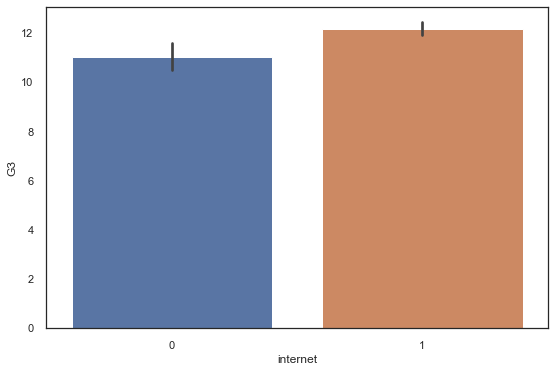

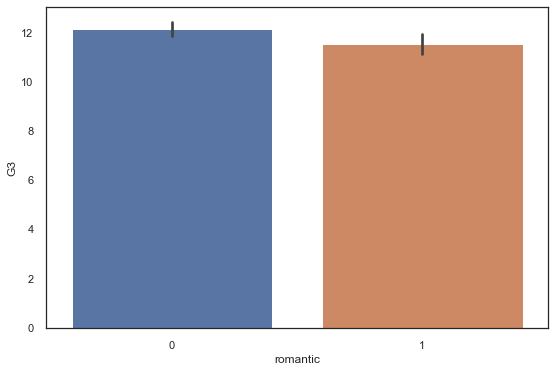

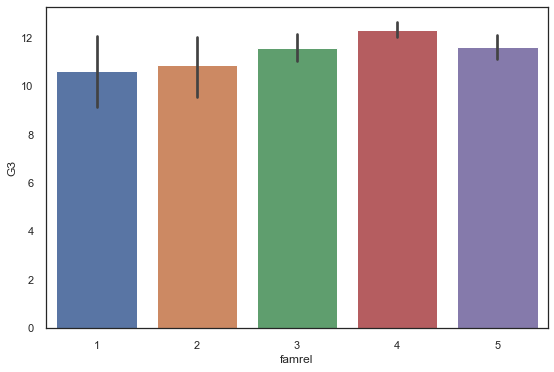

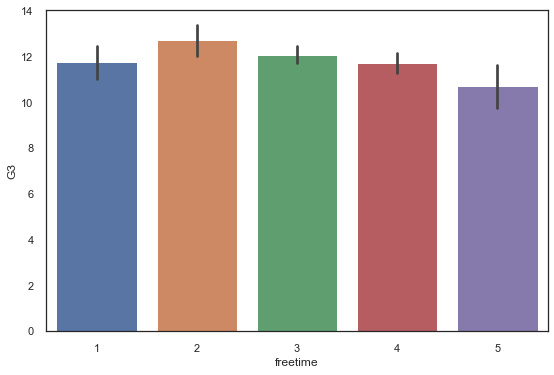

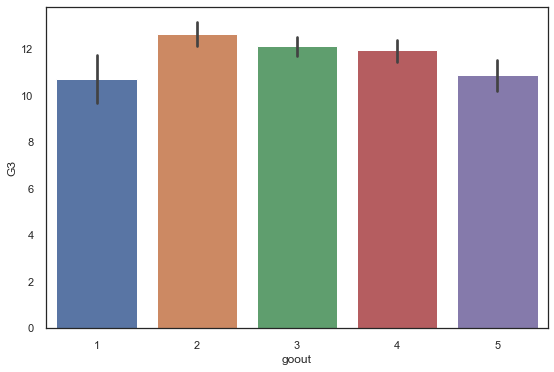

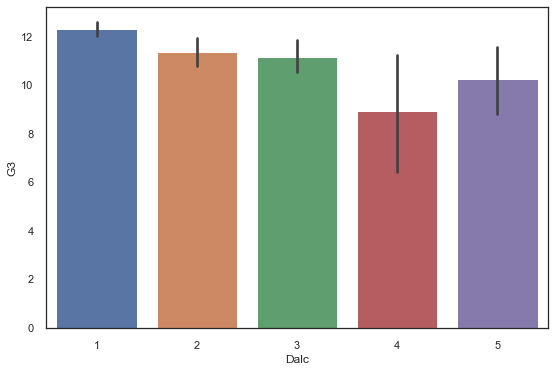

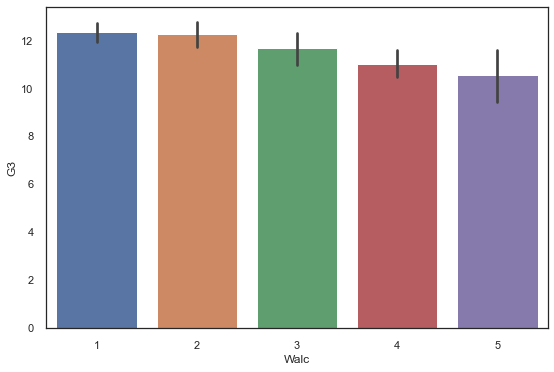

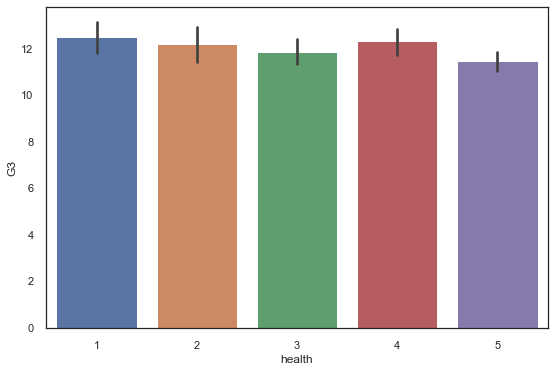

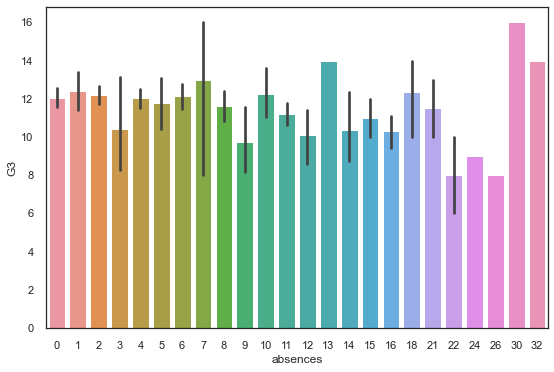

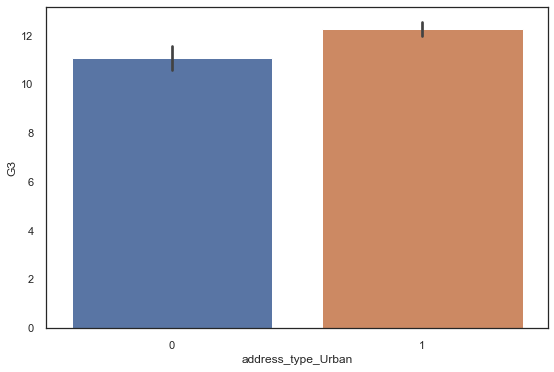

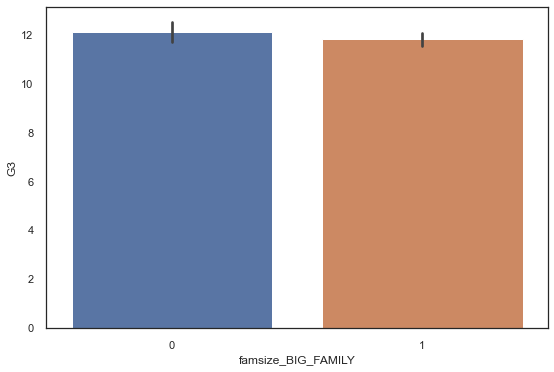

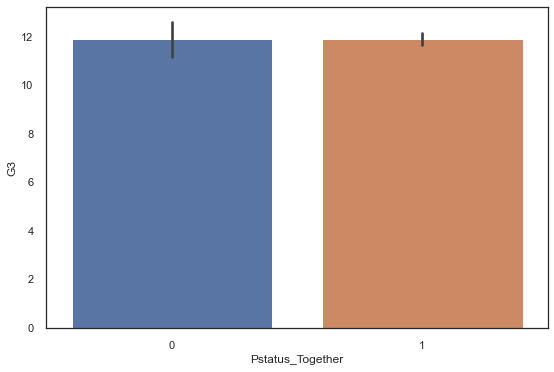

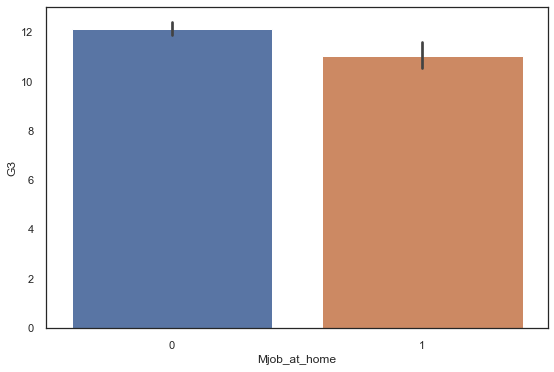

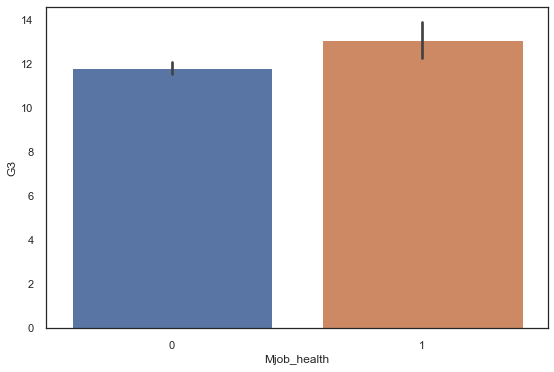

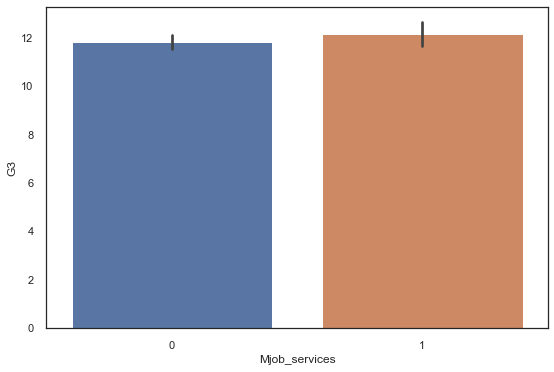

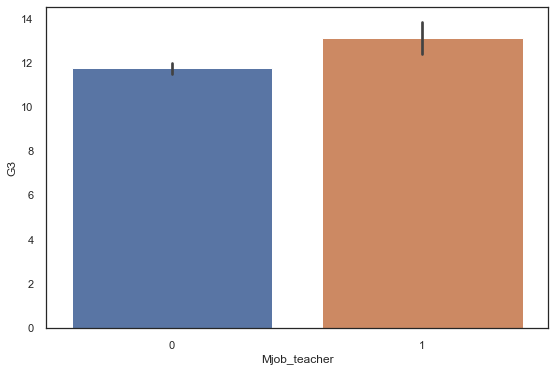

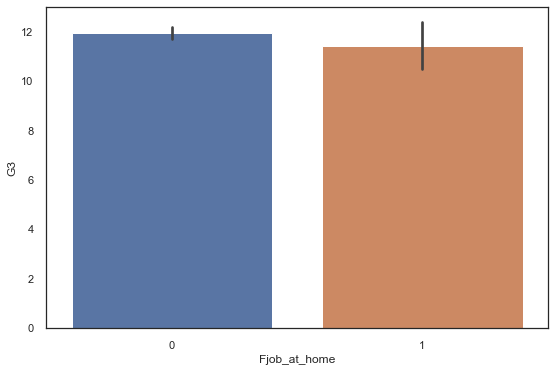

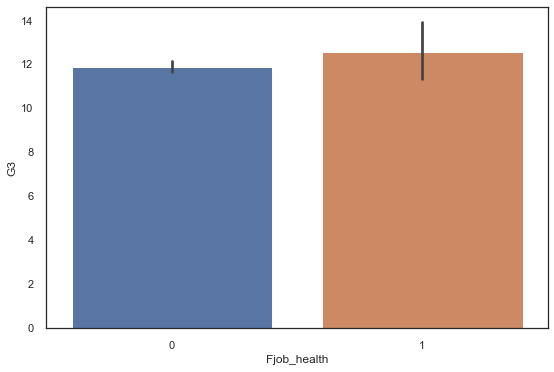

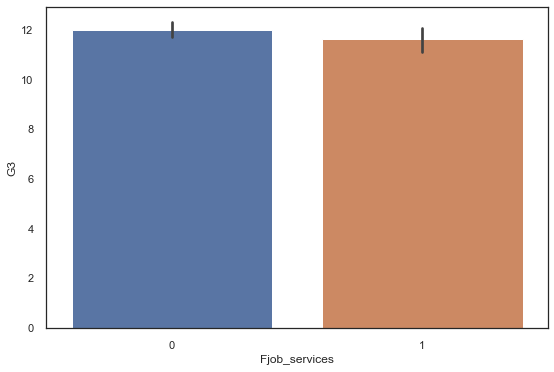

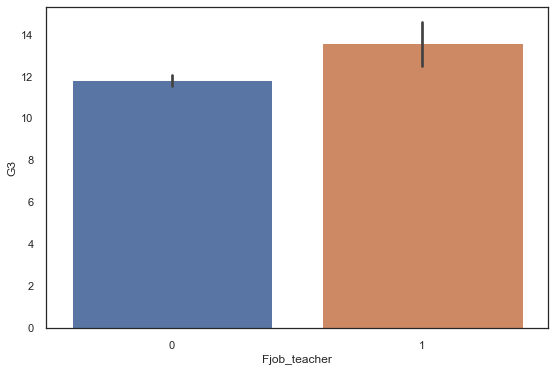

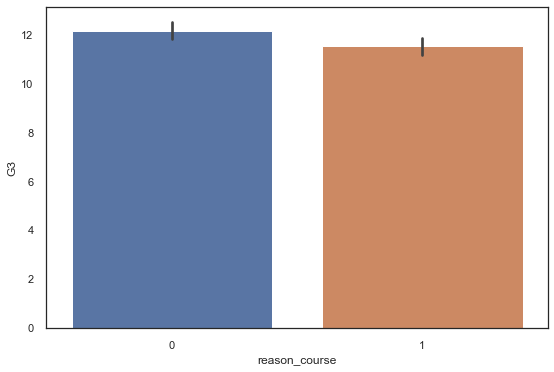

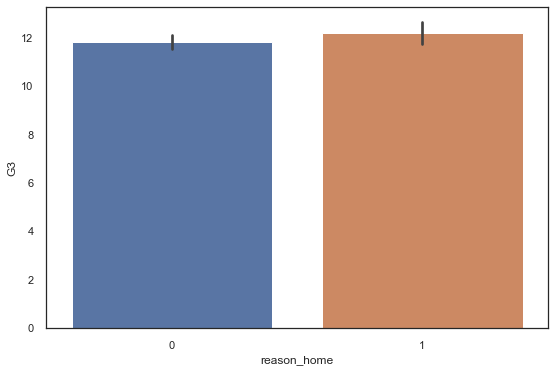

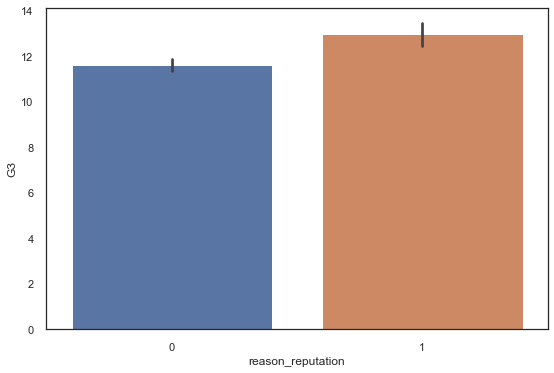

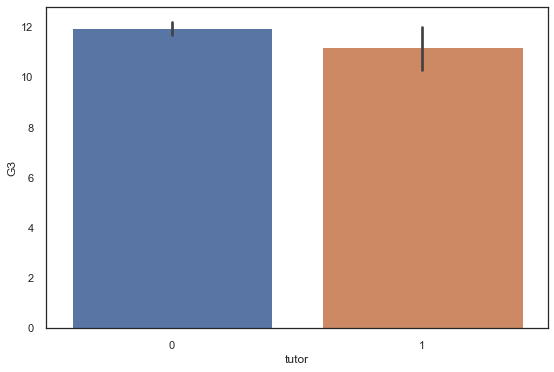

In [132]:
for i in p_feature:
    x = p_feature[i]
    sns.barplot(x=x, y=p.G3)
    plt.show()

In [133]:
p.head()

school sex  age  Medu  Fedu guardian  traveltime  studytime  failures  \
0     GP   F   18     4     4   mother           2          2         0   
1     GP   F   17     1     1   father           1          2         0   
2     GP   F   15     1     1   mother           1          2         0   
3     GP   F   15     4     2   mother           1          3         0   
4     GP   F   16     3     3   father           1          2         0   

   schoolsup  famsup  activities  nursery  higher  internet  romantic  famrel  \
0          1       0           0        1       1         0         0       4   
1          0       1           0        0       1         1         0       5   
2          1       0           0        1       1         1         0       4   
3          0       1           1        1       1         1         1       3   
4          0       1           0        1       1         0         0       4   

   freetime  goout  Dalc  Walc  health  absences  G1  G2  G3  \
0         3      4     1     1       3         4   0  11  11   
1         3      3     1     1       3         2   9  11  11   
2         3      2     2     3       3         6  12  13  12   
3         2      2     1     1       5         0  14  14  14   
4         3      2     1     2       5         0  11  13  13   

   address_type_Urban  famsize_BIG_FAMILY  Pstatus_Together  Mjob_at_home  \
0                   1                   1                 0             1   
1                   1                   1                 1             1   
2                   1                   0                 1             1   
3                   1                   1                 1             0   
4                   1                   1                 1             0   

   Mjob_health  Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  \
0            0              0             0             0            0   
1            0              0             0             0            0   
2            0              0             0             0            0   
3            1              0             0             0            0   
4            0              0             0             0            0   

   Fjob_services  Fjob_teacher  reason_course  reason_home  reason_reputation  \
0              0             1              1            0                  0   
1              0             0              1            0                  0   
2              0             0              0            0                  0   
3              1             0              0            1                  0   
4              0             0              0            1                  0   

   tutor  
0      0  
1      0  
2      0  
3      0  
4      0

In [259]:
'+'.join(p.columns)

'school+sex+age+Medu+Fedu+guardian+traveltime+studytime+failures+schoolsup+famsup+activities+nursery+higher+internet+romantic+famrel+freetime+goout+Dalc+Walc+health+absences+G1+G2+G3+address_type_Urban+famsize_BIG_FAMILY+Pstatus_Together+Mjob_at_home+Mjob_health+Mjob_services+Mjob_teacher+Fjob_at_home+Fjob_health+Fjob_services+Fjob_teacher+reason_course+reason_home+reason_reputation+tutor'

In [13]:
features = [x for x in p.columns if (x != 'school') and x != 'age' and x != 'guardian' and x != 'G1' and x != 'G2' and x!='G3' and x!= 'sex']

In [41]:
features

['Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'address_type_Urban',
 'famsize_BIG_FAMILY',
 'Pstatus_Together',
 'Mjob_at_home',
 'Mjob_health',
 'Mjob_services',
 'Mjob_teacher',
 'Fjob_at_home',
 'Fjob_health',
 'Fjob_services',
 'Fjob_teacher',
 'reason_course',
 'reason_home',
 'reason_reputation',
 'tutor']

In [15]:
p_feature = p[features]

In [16]:
p_feature.head()

Medu  Fedu  traveltime  studytime  failures  schoolsup  famsup  activities  \
0     4     4           2          2         0          1       0           0   
1     1     1           1          2         0          0       1           0   
2     1     1           1          2         0          1       0           0   
3     4     2           1          3         0          0       1           1   
4     3     3           1          2         0          0       1           0   

   nursery  higher  internet  romantic  famrel  freetime  goout  Dalc  Walc  \
0        1       1         0         0       4         3      4     1     1   
1        0       1         1         0       5         3      3     1     1   
2        1       1         1         0       4         3      2     2     3   
3        1       1         1         1       3         2      2     1     1   
4        1       1         0         0       4         3      2     1     2   

   health  absences  address_type_Urban  famsize_BIG_FAMILY  Pstatus_Together  \
0       3         4                   1                   1                 0   
1       3         2                   1                   1                 1   
2       3         6                   1                   0                 1   
3       5         0                   1                   1                 1   
4       5         0                   1                   1                 1   

   Mjob_at_home  Mjob_health  Mjob_services  Mjob_teacher  Fjob_at_home  \
0             1            0              0             0             0   
1             1            0              0             0             0   
2             1            0              0             0             0   
3             0            1              0             0             0   
4             0            0              0             0             0   

   Fjob_health  Fjob_services  Fjob_teacher  reason_course  reason_home  \
0            0              0             1              1            0   
1            0              0             0              1            0   
2            0              0             0              0            0   
3            0              1             0              0            1   
4            0              0             0              0            1   

   reason_reputation  tutor  
0                  0      0  
1                  0      0  
2                  0      0  
3                  0      0  
4                  0      0

In [22]:
model = ols(data = p, formula='G3~studytime+failures+schoolsup+higher+freetime+Dalc+Walc+health+address_type_Urban+Pstatus_Together+Mjob_health+Mjob_services+Mjob_teacher+Fjob_health+Fjob_services+reason_course+reason_home+reason_reputation').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     15.71
Date:                Fri, 11 Sep 2020   Prob (F-statistic):           4.67e-40
Time:                        09:14:46   Log-Likelihood:                -1561.2
No. Observations:                 649   AIC:                             3160.
Df Residuals:                     630   BIC:                             3245.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.9124      0.758     13.078      0.000       8.424      11.401
studytime              0.5108      0.138      3.709      0.000       0.240       0.781
failures              -1.4916      0.195     -7.664      0.000      -1.874      -1.109
schoolsup             -1.0429      0.357     -2.920      0.004      -1.744      -0.341
higher                 1.8288      0.378      4.837      0.000       1.086       2.571
freetime              -0.1685      0.105     -1.612      0.107      -0.374       0.037
Dalc                  -0.2269      0.151     -1.503      0.133      -0.523       0.070
Walc                  -0.1526      0.110     -1.393      0.164      -0.368       0.062
health                -0.1657      0.077     -2.166      0.031      -0.316      -0.015
address_type_Urban     0.7055      0.242      2.913      0.004       0.230       1.181
Pstatus_Together       0.2435      0.330      0.737      0.461      -0.405       0.892
Mjob_health            1.1107      0.444      2.504      0.013       0.240       1.982
Mjob_services          0.6261      0.283      2.213      0.027       0.070       1.182
Mjob_teacher           1.0041      0.361      2.785      0.006       0.296       1.712
Fjob_health           -0.4820      0.615     -0.784      0.433      -1.690       0.726
Fjob_services         -0.5802      0.251     -2.315      0.021      -1.072      -0.088
reason_course          0.7165      0.367      1.951      0.051      -0.005       1.438
reason_home            0.8107      0.400      2.024      0.043       0.024       1.597
reason_reputation      1.2379      0.406      3.045      0.002       0.440       2.036
==============================================================================
Omnibus:                      132.762   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              427.221
Skew:                          -0.960   Prob(JB):                     1.70e-93
Kurtosis:                       6.481   Cond. No.                         49.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mjob_health
0    AxesSubplot(0.08,0.07;0.87x0.81)
1    AxesSubplot(0.08,0.07;0.87x0.81)
Name: G3, dtype: object

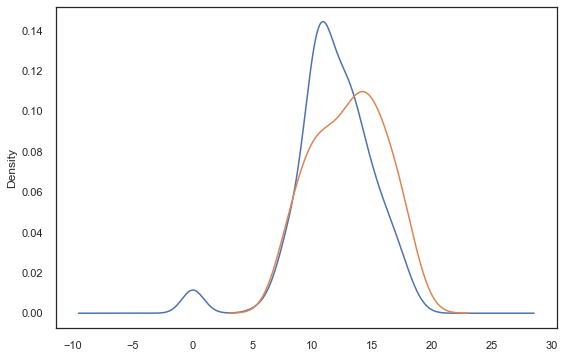

In [127]:
p.groupby('Mjob_health')['G3'].plot(kind='kde')

In [291]:
p_feature.head()

Medu  Fedu  traveltime  studytime  failures  schoolsup  famsup  activities  \
0     4     4           2          2         0          1       0           0   
1     1     1           1          2         0          0       1           0   
2     1     1           1          2         0          1       0           0   
3     4     2           1          3         0          0       1           1   
4     3     3           1          2         0          0       1           0   

   nursery  higher  internet  romantic  famrel  freetime  goout  Dalc  Walc  \
0        1       1         0         0       4         3      4     1     1   
1        0       1         1         0       5         3      3     1     1   
2        1       1         1         0       4         3      2     2     3   
3        1       1         1         1       3         2      2     1     1   
4        1       1         0         0       4         3      2     1     2   

   health  absences  address_type_Urban  famsize_BIG_FAMILY  Pstatus_Together  \
0       3         4                   1                   1                 0   
1       3         2                   1                   1                 1   
2       3         6                   1                   0                 1   
3       5         0                   1                   1                 1   
4       5         0                   1                   1                 1   

   Mjob_at_home  Mjob_health  Mjob_services  Mjob_teacher  Fjob_at_home  \
0             1            0              0             0             0   
1             1            0              0             0             0   
2             1            0              0             0             0   
3             0            1              0             0             0   
4             0            0              0             0             0   

   Fjob_health  Fjob_services  Fjob_teacher  reason_course  reason_home  \
0            0              0             1              1            0   
1            0              0             0              1            0   
2            0              0             0              0            0   
3            0              1             0              0            1   
4            0              0             0              0            1   

   reason_reputation  tutor  
0                  0      0  
1                  0      0  
2                  0      0  
3                  0      0  
4                  0      0

In [292]:
# #break the colums in to groups to plot 4 on a row at a time
# n = 4
# row_groups= [features[i:i+n] for i in range(0, len(features), n) ]
# for i in row_groups:
#     pp = sns.pairplot(data=p, y_vars=['G3'],x_vars=i, kind="reg", height=3)

In [293]:
# #break the colums in to groups to plot 4 on a row at a time
# n = 4
# row_groups= [features[i:i+n] for i in range(0, len(features), n) ]
# for i in row_groups:
#     pp = sns.pairplot(data=m, y_vars=['G3'],x_vars=i, kind="reg", height=3)

In [25]:
m[m['guardian'] == 'father']['G3'].mean()

10.688888888888888

In [295]:
m['G3'].mean()

10.415189873417722

In [296]:
from math import sqrt

In [297]:
# two sample t test 
guard_mean = m[m['guardian'] == 'other']['G3'].mean()
math_mean = m['G3'].mean()
std = m['G3'].std()
n = m['G3'].count()
n
ans = ((guard_mean - math_mean) / (sqrt(std/n)))
ans
# we reject the null hypothesis that having an average math score 
# isn't affected  by your guardian being mother father or 
# We believe that having a mother or father present will increase math scores


-12.560174154991815

In [298]:
p.head()

school sex  age  Medu  Fedu guardian  traveltime  studytime  failures  \
0     GP   F   18     4     4   mother           2          2         0   
1     GP   F   17     1     1   father           1          2         0   
2     GP   F   15     1     1   mother           1          2         0   
3     GP   F   15     4     2   mother           1          3         0   
4     GP   F   16     3     3   father           1          2         0   

   schoolsup  famsup  activities  nursery  higher  internet  romantic  famrel  \
0          1       0           0        1       1         0         0       4   
1          0       1           0        0       1         1         0       5   
2          1       0           0        1       1         1         0       4   
3          0       1           1        1       1         1         1       3   
4          0       1           0        1       1         0         0       4   

   freetime  goout  Dalc  Walc  health  absences  G1  G2  G3  \
0         3      4     1     1       3         4   0  11  11   
1         3      3     1     1       3         2   9  11  11   
2         3      2     2     3       3         6  12  13  12   
3         2      2     1     1       5         0  14  14  14   
4         3      2     1     2       5         0  11  13  13   

   address_type_Urban  famsize_BIG_FAMILY  Pstatus_Together  Mjob_at_home  \
0                   1                   1                 0             1   
1                   1                   1                 1             1   
2                   1                   0                 1             1   
3                   1                   1                 1             0   
4                   1                   1                 1             0   

   Mjob_health  Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  \
0            0              0             0             0            0   
1            0              0             0             0            0   
2            0              0             0             0            0   
3            1              0             0             0            0   
4            0              0             0             0            0   

   Fjob_services  Fjob_teacher  reason_course  reason_home  reason_reputation  \
0              0             1              1            0                  0   
1              0             0              1            0                  0   
2              0             0              0            0                  0   
3              1             0              0            1                  0   
4              0             0              0            1                  0   

   tutor  
0      0  
1      0  
2      0  
3      0  
4      0

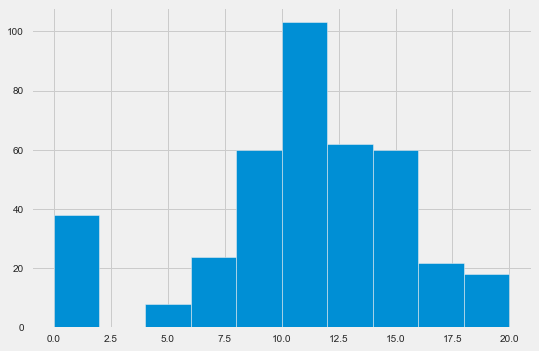

In [26]:
m.G3.hist()

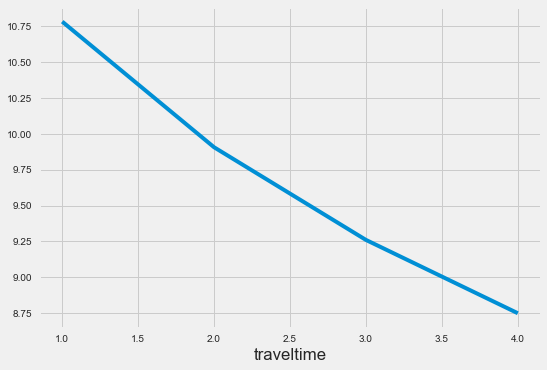

In [27]:
m.groupby('traveltime')['G3'].mean().plot()

In [301]:
p.traveltime.value_counts()

1    366
2    213
3     54
4     16
Name: traveltime, dtype: int64

In [302]:
p_feature

Medu  Fedu  traveltime  studytime  failures  schoolsup  famsup  \
0       4     4           2          2         0          1       0   
1       1     1           1          2         0          0       1   
2       1     1           1          2         0          1       0   
3       4     2           1          3         0          0       1   
4       3     3           1          2         0          0       1   
..    ...   ...         ...        ...       ...        ...     ...   
644     2     3           1          3         1          0       0   
645     3     1           1          2         0          0       1   
646     1     1           2          2         0          0       0   
647     3     1           2          1         0          0       0   
648     3     2           3          1         0          0       0   

     activities  nursery  higher  internet  romantic  famrel  freetime  goout  \
0             0        1       1         0         0       4         3      4   
1             0        0       1         1         0       5         3      3   
2             0        1       1         1         0       4         3      2   
3             1        1       1         1         1       3         2      2   
4             0        1       1         0         0       4         3      2   
..          ...      ...     ...       ...       ...     ...       ...    ...   
644           1        0       1         1         0       5         4      2   
645           0        1       1         1         0       4         3      4   
646           1        1       1         0         0       1         1      1   
647           0        0       1         1         0       2         4      5   
648           0        0       1         1         0       4         4      1   

     Dalc  Walc  health  absences  address_type_Urban  famsize_BIG_FAMILY  \
0       1     1       3         4                   1                   1   
1       1     1       3         2                   1                   1   
2       2     3       3         6                   1                   0   
3       1     1       5         0                   1                   1   
4       1     2       5         0                   1                   1   
..    ...   ...     ...       ...                 ...                 ...   
644     1     2       5         4                   0                   1   
645     1     1       1         4                   1                   0   
646     1     1       5         6                   1                   1   
647     3     4       2         6                   1                   0   
648     3     4       5         4                   0                   0   

     Pstatus_Together  Mjob_at_home  Mjob_health  Mjob_services  Mjob_teacher  \
0                   0             1            0              0             0   
1                   1             1            0              0             0   
2                   1             1            0              0             0   
3                   1             0            1              0             0   
4                   1             0            0              0             0   
..                ...           ...          ...            ...           ...   
644                 1             0            0              1             0   
645                 1             0            0              0             1   
646                 1             0            0              0             0   
647                 1             0            0              1             0   
648                 1             0            0              1             0   

     Fjob_at_home  Fjob_health  Fjob_services  Fjob_teacher  reason_course  \
0               0            0              0             1              1   
1               0            0              0             0              1   
2               0            0              0  

In [303]:
p_feature.describe()

Medu        Fedu  traveltime   studytime    failures   schoolsup  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     2.514638    2.306626    1.568567    1.930663    0.221880    0.104777   
std      1.134552    1.099931    0.748660    0.829510    0.593235    0.306502   
min      0.000000    0.000000    1.000000    1.000000    0.000000    0.000000   
25%      2.000000    1.000000    1.000000    1.000000    0.000000    0.000000   
50%      2.000000    2.000000    1.000000    2.000000    0.000000    0.000000   
75%      4.000000    3.000000    2.000000    2.000000    0.000000    0.000000   
max      4.000000    4.000000    4.000000    4.000000    3.000000    1.000000   

           famsup  activities     nursery      higher    internet    romantic  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     0.613251    0.485362    0.802773    0.893683    0.767334    0.368259   
std      0.487381    0.500171    0.398212    0.308481    0.422857    0.482704   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    1.000000    1.000000    1.000000    0.000000   
50%      1.000000    0.000000    1.000000    1.000000    1.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     3.930663    3.180277    3.184900    1.502311    2.280431    3.536210   
std      0.955717    1.051093    1.175766    0.924834    1.284380    1.446259   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    2.000000    1.000000    1.000000    2.000000   
50%      4.000000    3.000000    3.000000    1.000000    2.000000    4.000000   
75%      5.000000    4.000000    4.000000    2.000000    3.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

         absences  address_type_Urban  famsize_BIG_FAMILY  Pstatus_Together  \
count  649.000000          649.000000          649.000000        649.000000   
mean     3.659476            0.696456            0.704160          0.876733   
std      4.640759            0.460143            0.456771          0.328996   
min      0.000000            0.000000            0.000000          0.000000   
25%      0.000000            0.000000            0.000000          1.000000   
50%      2.000000            1.000000            1.000000          1.000000   
75%      6.000000            1.000000            1.000000          1.000000   
max     32.000000            1.000000            1.000000          1.000000   

       Mjob_at_home  Mjob_health  Mjob_services  Mjob_teacher  Fjob_at_home  \
count    649.000000   649.000000     649.000000     649.00000    649.000000   
mean       0.208012     0.073960       0.209553       0.11094      0.064715   
std        0.406199     0.261908       0.407304       0.31430      0.246212   
min        0.000000     0.000000       0.000000       0.00000      0.000000   
25%        0.000000     0.000000       0.000000       0.00000      0.000000   
50%        0.000000     0.000000       0.000000       0.00000      0.000000   
75%        0.000000     0.000000       0.000000       0.00000      0.000000   
max        1.000000     1.000000       1.000000       1.00000      1.000000   

       Fjob_health  Fjob_services  Fjob_teacher  reason_course  reason_home  \
count   649.000000     649.000000    649.000000     649.000000   649.000000   
mean      0.035439       0.278891      0.055470       0.439137     0.229584   
std       0.185030       0.448799      0.229072       0.496665     0.420890   
min       0.000000       0.000000      0.000000       0.000000     0.000000   
25% 

In [304]:
p_feature.corr()

Medu      Fedu  traveltime  studytime  failures  \
Medu                1.000000  0.647477   -0.265079   0.097006 -0.172210   
Fedu                0.647477  1.000000   -0.208288   0.050400 -0.165915   
traveltime         -0.265079 -0.208288    1.000000  -0.063154  0.097730   
studytime           0.097006  0.050400   -0.063154   1.000000 -0.147441   
failures           -0.172210 -0.165915    0.097730  -0.147441  1.000000   
schoolsup          -0.022168  0.023572   -0.044807   0.089316 -0.000745   
famsup              0.120491  0.135191   -0.039289   0.143509 -0.006982   
activities          0.119354  0.079700   -0.033376   0.070080  0.000561   
nursery             0.125951  0.074863   -0.011509   0.042630 -0.069241   
higher              0.213896  0.191735   -0.071958   0.188256 -0.309400   
internet            0.266052  0.183483   -0.190826   0.037529 -0.095330   
romantic           -0.030992 -0.067675    0.004751   0.033036  0.069901   
famrel              0.024421  0.020256   -0.009521  -0.004127 -0.062645   
freetime           -0.019686  0.006841    0.000937  -0.068829  0.108995   
goout               0.009536  0.027690    0.057454  -0.075442  0.045078   
Dalc               -0.007018  0.000061    0.092824  -0.137585  0.105949   
Walc               -0.019766  0.038445    0.057007  -0.214925  0.082266   
health              0.004614  0.044910   -0.048261  -0.056433  0.035588   
absences           -0.008577  0.029859   -0.008149  -0.118389  0.122779   
address_type_Urban  0.190320  0.141493   -0.344902   0.062023 -0.063824   
famsize_BIG_FAMILY  0.014325  0.039538   -0.012794   0.010945  0.066068   
Pstatus_Together   -0.057174 -0.031856    0.040633  -0.008748 -0.009881   
Mjob_at_home       -0.376636 -0.198240    0.173772  -0.039569  0.096358   
Mjob_health         0.261215  0.140789   -0.104606  -0.018978 -0.016391   
Mjob_services       0.130272  0.104368   -0.072497   0.029369  0.011652   
Mjob_teacher        0.449847  0.312130   -0.097961   0.035469 -0.123945   
Fjob_at_home       -0.097313 -0.107575   -0.040854  -0.008220  0.038892   
Fjob_health         0.155576  0.227081   -0.089981   0.096471 -0.057688   
Fjob_services      -0.012576  0.026575   -0.031740   0.014716 -0.006725   
Fjob_teacher        0.258136  0.348874   -0.040209  -0.020335 -0.079352   
reason_course      -0.119602 -0.068893    0.132636  -0.083301  0.161132   
reason_home         0.036580  0.017710   -0.125946  -0.011796 -0.080719   
reason_reputation   0.132502  0.085076   -0.076058   0.179023 -0.111185   
tutor               0.113973  0.094628   -0.044842  -0.002314  0.069416   

                    schoolsup    famsup  activities   nursery    higher  \
Medu                -0.022168  0.120491    0.119354  0.125951  0.213896   
Fedu                 0.023572  0.135191    0.079700  0.074863  0.191735   
traveltime          -0.044807 -0.039289   -0.033376 -0.011509 -0.071958   
studytime            0.089316  0.143509    0.070080  0.042630  0.188256   
failures            -0.000745 -0.006982    0.000561 -0.069241 -0.309400   
schoolsup            1.000000  0.075402   -0.030246  0.017846  0.085355   
famsup               0.075402  1.000000   -0.007433  0.027799  0.085340   
activities          -0.030246 -0.007433    1.000000  0.039719  0.044908   
nursery              0.017846  0.027799    0.039719  1.000000  0.042605   
higher               0.085355  0.085340    0.044908  0.042605  1.000000   
internet            -0.025942  0.071891    0.082375 -0.007159  0.070345   
romantic            -0.094310 -0.023398    0.057517 -0.022984 -0.099389   
famrel              -0.012038  0.015228    0.057597  0.041055  0.048239   
freetime            -0.015611  0.003764    0.150329 -0.007096 -0.102618   
goout               -0.058124  0.017262    0.088582  0.018679 -0.069105   
Dalc                -0.028076 -0.016844    0.022592 -0.078376 -0.131663   
Walc                -0.098275 -0.065605    0.032824 -0.075748 -0.084327   
health               0.022760  0.018803    0.013

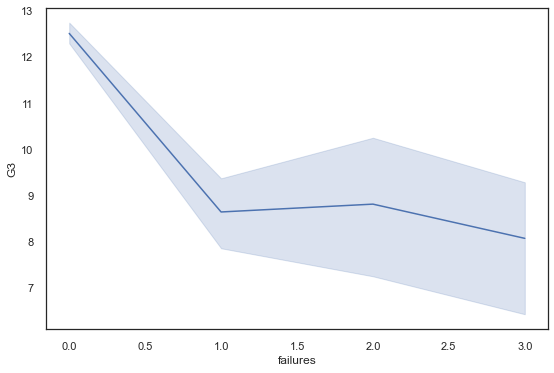

In [305]:
sns.lineplot(x=p.failures, y=p.G3)

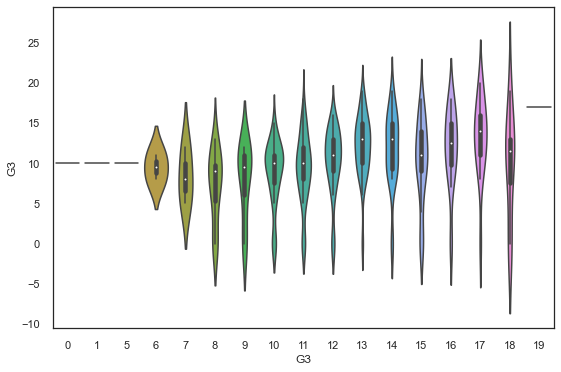

In [306]:
sns.violinplot(x=p.G3, y=m.G3)

In [101]:
features
p_feature
target=p.G3

In [102]:
X_train, X_test, y_train, y_test = train_test_split(p_feature, target, random_state=9,test_size=0.2)


In [103]:
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=p_feature.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=p_feature.columns)

In [105]:
selector = SelectKBest(f_regression, k=15)

selector.fit(X_train, y_train)

SelectKBest(k=15, score_func=<function f_regression at 0x7fa23c77e5e0>)

In [106]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [107]:
len(removed_columns)

19

In [108]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)




Training Root Mean Squared Error: 2.7680296954322188
Testing Root Mean Squared Error: 2.5622961196902727


In [31]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 2.691212447987795


In [32]:
#use fitted model to predict on the test examples
y_test_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', (train_rmse), "vs. Testing: ", (test_rmse))

Testing Root Mean Squared Error: 2.5818025560884137
Training:  2.691212447987795 vs. Testing:  2.5818025560884137


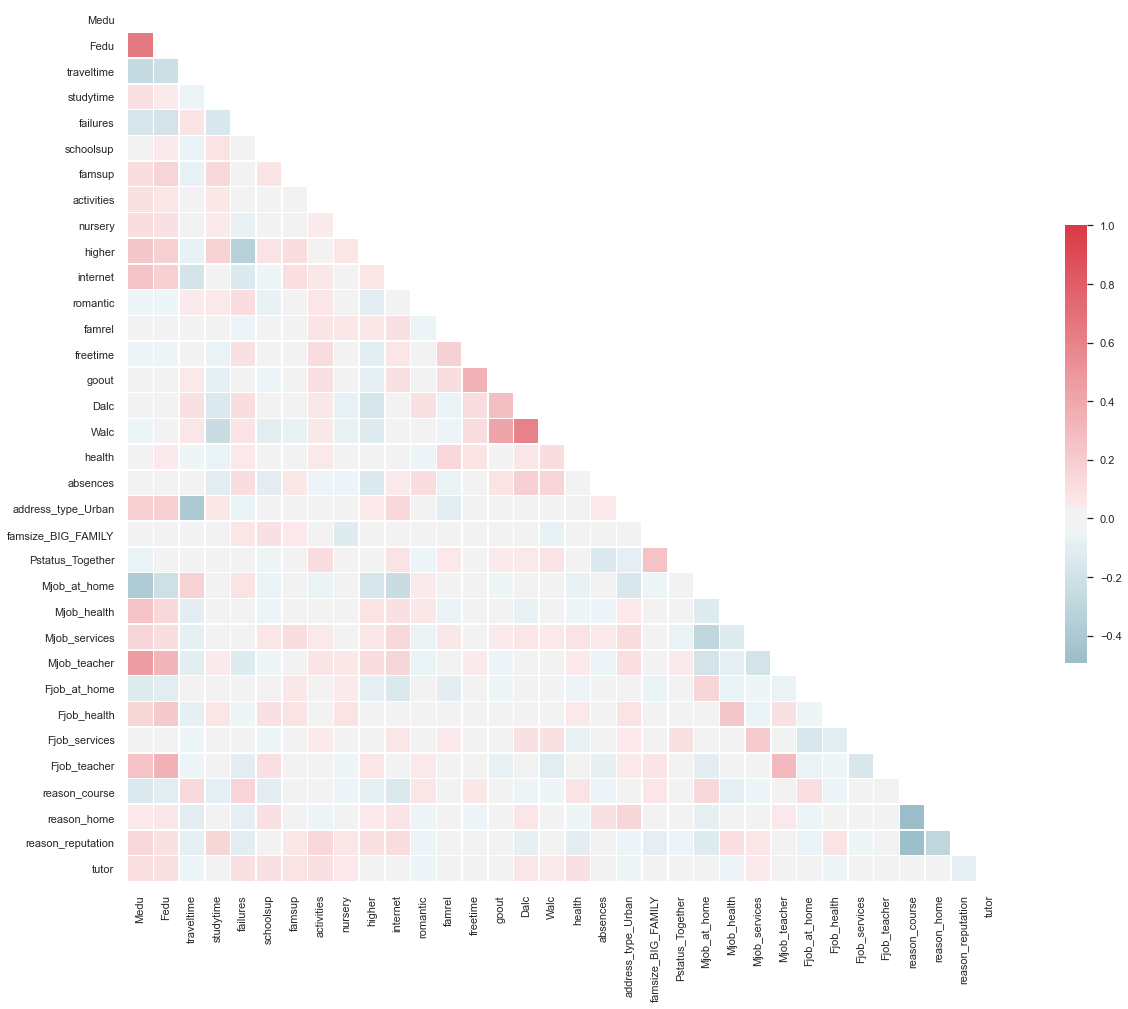

In [33]:
sns.set(style="white")

# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

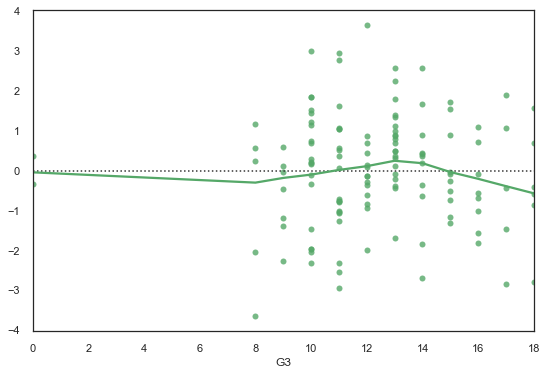

In [34]:
sns.residplot(y_test, y_test_pred,lowess=True, color="g")

In [145]:
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(p_feature, target, random_state=9,test_size=0.2)

In [146]:
# Create correlation matrix
corr_matrix = X_train_8.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

Medu    Fedu  traveltime  studytime  failures  schoolsup  \
Medu                 NaN  0.6525    0.254865   0.100350  0.170706   0.016654   
Fedu                 NaN     NaN    0.220344   0.045355  0.186576   0.047822   
traveltime           NaN     NaN         NaN   0.046597  0.078104   0.058941   
studytime            NaN     NaN         NaN        NaN  0.154097   0.079430   
failures             NaN     NaN         NaN        NaN       NaN   0.033556   
schoolsup            NaN     NaN         NaN        NaN       NaN        NaN   
famsup               NaN     NaN         NaN        NaN       NaN        NaN   
activities           NaN     NaN         NaN        NaN       NaN        NaN   
nursery              NaN     NaN         NaN        NaN       NaN        NaN   
higher               NaN     NaN         NaN        NaN       NaN        NaN   
internet             NaN     NaN         NaN        NaN       NaN        NaN   
romantic             NaN     NaN         NaN        NaN       NaN        NaN   
famrel               NaN     NaN         NaN        NaN       NaN        NaN   
freetime             NaN     NaN         NaN        NaN       NaN        NaN   
goout                NaN     NaN         NaN        NaN       NaN        NaN   
Dalc                 NaN     NaN         NaN        NaN       NaN        NaN   
Walc                 NaN     NaN         NaN        NaN       NaN        NaN   
health               NaN     NaN         NaN        NaN       NaN        NaN   
absences             NaN     NaN         NaN        NaN       NaN        NaN   
address_type_Urban   NaN     NaN         NaN        NaN       NaN        NaN   
famsize_BIG_FAMILY   NaN     NaN         NaN        NaN       NaN        NaN   
Pstatus_Together     NaN     NaN         NaN        NaN       NaN        NaN   
Mjob_at_home         NaN     NaN         NaN        NaN       NaN        NaN   
Mjob_health          NaN     NaN         NaN        NaN       NaN        NaN   
Mjob_services        NaN     NaN         NaN        NaN       NaN        NaN   
Mjob_teacher         NaN     NaN         NaN        NaN       NaN        NaN   
Fjob_at_home         NaN     NaN         NaN        NaN       NaN        NaN   
Fjob_health          NaN     NaN         NaN        NaN       NaN        NaN   
Fjob_services        NaN     NaN         NaN        NaN       NaN        NaN   
Fjob_teacher         NaN     NaN         NaN        NaN       NaN        NaN   
reason_course        NaN     NaN         NaN        NaN       NaN        NaN   
reason_home          NaN     NaN         NaN        NaN       NaN        NaN   
reason_reputation    NaN     NaN         NaN        NaN       NaN        NaN   
tutor                NaN     NaN         NaN        NaN       NaN        NaN   

                      famsup  activities   nursery    higher  internet  \
Medu                0.116213    0.097407  0.113538  0.227379  0.255099   
Fedu                0.158355    0.070199  0.094952  0.192107  0.187213   
traveltime          0.070738    0.005972  0.014845  0.071844  0.181289   
studytime           0.135786    0.057600  0.047619  0.174988  0.012463   
failures            0.019704    0.016920  0.067263  0.330759  0.135531   
schoolsup           0.077883    0.028027  0.011341  0.082282  0.040993   
famsup                   NaN    0.016454  0.018938  0.112503  0.104405   
activities               NaN         NaN  0.048442  0.032153  0.057900   
nursery                  NaN         NaN       NaN  0.065306  0.016346   
higher                   NaN         NaN       NaN       NaN  0.066414   
internet                 NaN         NaN       NaN       NaN       NaN   
romantic                 NaN         NaN       NaN       NaN       NaN   
famrel                   NaN         NaN       NaN       NaN       NaN   
freetime                 NaN         NaN       NaN       NaN       NaN   
goout                    NaN         NaN       NaN       NaN       NaN   
Dalc                     NaN       

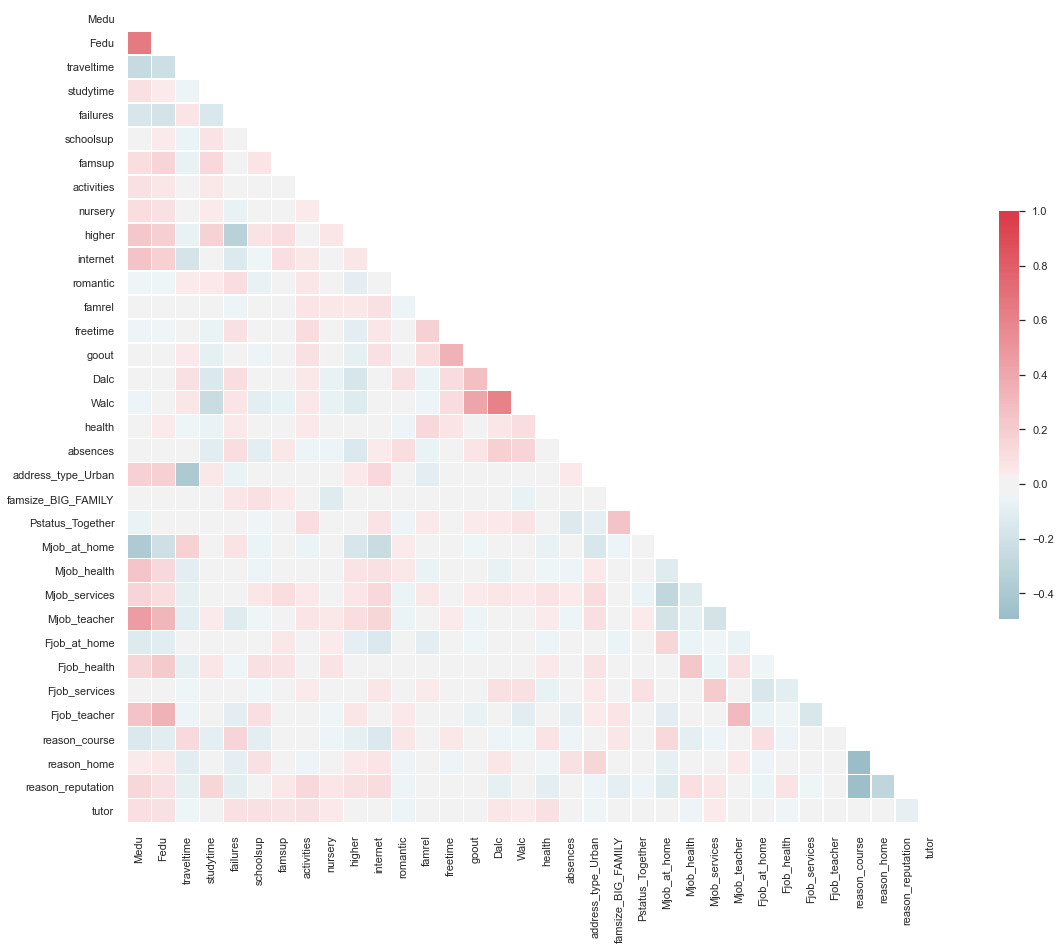

In [148]:
sns.set(style="white")

# Compute the correlation matrix
corr = X_train_8.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [149]:
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

#if you change inplace to True it will go through and drop all of those columns from the dataset
X_train_8.drop(columns=to_drop, inplace=False)
X_test_8.drop(columns=to_drop, inplace=False)


Medu  Fedu  traveltime  studytime  failures  schoolsup  famsup  \
314     1     2           1          2         0          0       1   
189     4     3           2          2         0          0       0   
475     2     2           2          3         0          0       1   
39      2     2           1          1         0          1       1   
309     4     2           1          2         0          0       1   
..    ...   ...         ...        ...       ...        ...     ...   
551     3     2           2          2         0          0       1   
633     4     4           1          2         0          0       0   
334     2     1           1          3         0          0       0   
451     1     2           2          2         0          0       0   
185     1     0           2          2         0          0       1   

     activities  nursery  higher  internet  romantic  famrel  freetime  goout  \
314           1        0       1         0         1       3         5      2   
189           1        1       1         1         0       4         4      4   
475           1        1       1         0         0       5         3      2   
39            1        1       1         0         0       4         3      1   
309           1        1       1         1         1       5         4      5   
..          ...      ...     ...       ...       ...     ...       ...    ...   
551           0        1       1         1         0       4         1      2   
633           1        1       1         1         0       5         4      3   
334           1        1       1         1         0       4         2      4   
451           0        1       1         0         0       4         3      3   
185           1        1       1         1         1       4         3      2   

     Dalc  Walc  health  absences  address_type_Urban  famsize_BIG_FAMILY  \
314     2     2       1         2                   0                   1   
189     4     4       4         0                   1                   0   
475     1     1       4         0                   1                   1   
39      1     1       2         8                   0                   1   
309     1     3       5         4                   1                   1   
..    ...   ...     ...       ...                 ...                 ...   
551     2     2       1         0                   1                   1   
633     3     4       2         1                   0                   0   
334     1     3       2         0                   1                   1   
451     1     1       5         0                   0                   1   
185     1     1       3         0                   1                   1   

     Pstatus_Together  Mjob_at_home  Mjob_health  Mjob_services  Mjob_teacher  \
314                 1             1            0              0             0   
189                 1             0            0              0             1   
475                 1             0            0              0             0   
39                  1             1            0              0             0   
309                 1             0            1              0             0   
..                ...           ...          ...            ...           ...   
551                 1             0            0              0             0   
633                 1             0            0              0             1   
334                 1             0            0              1             0   
451                 1             0            0              0             0   
185                 1             0            0              0             0   

     Fjob_at_home  Fjob_health  Fjob_services  Fjob_teacher  reason_course  \
314             1            0              0             0              0   
189             0            0              0             0              1   
475             0            0              1  

In [150]:
to_drop

[]

In [152]:
[variance_inflation_factor(X_train.values, i) for i in range(X_train_8.shape[1])]

[2.6850267353267885,
 2.0729396882606888,
 1.3105030876361303,
 1.1874900940689834,
 1.254288904594353,
 1.122280761067253,
 1.1159204061711956,
 1.1195733290358398,
 1.076009402217287,
 1.2662297813264733,
 1.2243618620765757,
 1.0993037933759835,
 1.1424340856027,
 1.239330235912842,
 1.4387521592686527,
 1.7562758546386077,
 2.000888917768616,
 1.1324560180366023,
 1.1690316486366221,
 1.295504472329142,
 1.1560788439296583,
 1.1827135197928642,
 1.3803088213588313,
 1.3681693524607486,
 1.4722345746543817,
 1.7605569192812525,
 1.1333067056109154,
 1.2121022971195166,
 1.228556112062388,
 1.3809750407367618,
 3.2068390066016708,
 2.7737027347929137,
 2.863962867530431,
 1.1125795836746826]

In [153]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(p_feature.values, i) for i in range(p_feature.shape[1])]
vif["features"] = p_feature.columns
vif.round(1)

VIF Factor            features
0         15.1                Medu
1         11.0                Fedu
2          6.0          traveltime
3          7.2           studytime
4          1.4            failures
5          1.2           schoolsup
6          2.8              famsup
7          2.2          activities
8          5.2             nursery
9         10.7              higher
10         5.2            internet
11         1.7            romantic
12        17.1              famrel
13        12.1            freetime
14        11.7               goout
15         6.4                Dalc
16         8.4                Walc
17         7.5              health
18         1.9            absences
19         3.9  address_type_Urban
20         3.7  famsize_BIG_FAMILY
21         8.8    Pstatus_Together
22         1.7        Mjob_at_home
23         1.5         Mjob_health
24         1.8       Mjob_services
25         1.9        Mjob_teacher
26         1.2        Fjob_at_home
27         1.3         Fjob_health
28         1.7       Fjob_services
29         1.4        Fjob_teacher
30         4.9       reason_course
31         3.1         reason_home
32         3.2   reason_reputation
33         1.2               tutor

In [154]:
p_feature.corrwith(target).abs()


Medu                  0.240151
Fedu                  0.211800
traveltime            0.127173
studytime             0.249789
failures              0.393316
schoolsup             0.066405
famsup                0.059206
activities            0.059791
nursery               0.028752
higher                0.332172
internet              0.150025
romantic              0.090583
famrel                0.063361
freetime              0.122705
goout                 0.087641
Dalc                  0.204719
Walc                  0.176619
health                0.098851
absences              0.091379
address_type_Urban    0.167637
famsize_BIG_FAMILY    0.045016
Pstatus_Together      0.000754
Mjob_at_home          0.136778
Mjob_health           0.101244
Mjob_services         0.038447
Mjob_teacher          0.134910
Fjob_at_home          0.038904
Fjob_health           0.039142
Fjob_services         0.053204
Fjob_teacher          0.125916
reason_course         0.098305
reason_home           0.046537
reason_r

In [203]:
X_train.shape

(519, 34)

In [204]:
selector = SelectKBest(f_regression, k=20)

selector.fit(X_train, y_train)

SelectKBest(k=20, score_func=<function f_regression at 0x7fd5e04283a0>)

In [205]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [206]:
list(selected_columns)

['Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'higher',
 'internet',
 'romantic',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'address_type_Urban',
 'Mjob_at_home',
 'Mjob_teacher',
 'Fjob_teacher',
 'reason_course',
 'reason_reputation']

In [207]:
list(removed_columns)

['schoolsup',
 'famsup',
 'activities',
 'nursery',
 'famrel',
 'famsize_BIG_FAMILY',
 'Pstatus_Together',
 'Mjob_health',
 'Mjob_services',
 'Fjob_at_home',
 'Fjob_health',
 'Fjob_services',
 'reason_home',
 'tutor']

In [209]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)




Training Root Mean Squared Error: 0.26628380464640483
Testing Root Mean Squared Error: 2.543213046165145


In [197]:
print('Original: ', test_rmse, '\n',
      "KBest:   ", testK_rmse,'\n')

Original:  2.5818025560884137 
 KBest:    2.54892608470929 



In [165]:
ols = linear_model.LinearRegression()

In [166]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)



RFECV(cv=5, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', verbose=1)

In [167]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]


In [168]:
list(removed_rfe)

[]

In [170]:
len(list(selected_rfe))

34

In [171]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)




Training Root Mean Squared Error: 2.691212447987795
Testing Root Mean Squared Error: 2.5818025560884137


In [172]:
print('Original: ', test_rmse, '\n',
      "KBest:   ", testK_rmse,'\n',
      "RFE:     ", testRFE_rmse)

Original:  2.5818025560884137 
 KBest:    2.600425493964838 
 RFE:      2.5818025560884137


TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [36]:
m_orig

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0    course   mother           2          2         0       yes     no   no   
1    course   father           1          2         0        no    yes   no   
2     other   mother           1          2         3       yes     no  yes   
3      home   mother           1          3         0        no    yes  yes   
4      home   father           1          2         0        no    yes  yes   
..      ...      ...         ...        ...       ...       ...    ...  ...   
390  course    other           1          2         2        no    yes  yes   
391  course   mother           2          1         0        no     no   no   
392  course    other           1          1         3        no     no   no   
393  course   mother           3          1         0        no     no   no   
394  course   father           1          1         0        no     no   no   

    activities nursery higher internet romantic  famrel  freetime  goout  \
0           no     yes    yes       no       no       4         3      4   
1           no      no    yes      yes       no       5         3      3   
2           no     yes    yes      yes       no       4         3      2   
3          yes     yes    yes      yes      yes       3         2      2   
4           no     yes    yes       no       no       4         3      2   
..         ...     ...    ...      ...      ...     ...       ...    ...   
390         no     yes    yes       no       no       5         5      4   
391         no      no    yes      yes       no       2         4      5   
392         no      no    yes       no       no       5         5      3   
393         no      no    yes      yes       no       4         4      1   
394         no     yes    yes      yes       no       3         2      3   

     Dalc  Walc  health  absences  G1  G2  G3  
0       1     1       3         6   5   6   6  
1       1     1       3         4   5   5   6  
2       2     3       3        10   7   8  10  
3       1     1       5         2  15  14  15  
4       1     2       5         4   6  10  10  
..    ...   ...     ...       ...  ..  ..  ..  
390     4     5       4        11   9   9   9  
391     3     4       2         3  14  16  16  
392     3     3       3         3  10   8   7  
393     3     4       5         0  11  12  10  
394     3     3       5         5   8   9   9  

[395 rows x 33 columns]

In [37]:
m.head()

school sex  age  Medu  Fedu guardian  traveltime  studytime  failures  \
0     GP   F   18     4     4   mother           2          2         0   
1     GP   F   17     1     1   father           1          2         0   
2     GP   F   15     1     1   mother           1          2         3   
3     GP   F   15     4     2   mother           1          3         0   
4     GP   F   16     3     3   father           1          2         0   

   schoolsup  famsup  activities  nursery  higher  internet  romantic  famrel  \
0          1       0           0        1       1         0         0       4   
1          0       1           0        0       1         1         0       5   
2          1       0           0        1       1         1         0       4   
3          0       1           1        1       1         1         1       3   
4          0       1           0        1       1         0         0       4   

   freetime  goout  Dalc  Walc  health  absences  G1  G2  G3  \
0         3      4     1     1       3         6   5   6   6   
1         3      3     1     1       3         4   5   5   6   
2         3      2     2     3       3        10   7   8  10   
3         2      2     1     1       5         2  15  14  15   
4         3      2     1     2       5         4   6  10  10   

   address_type_Urban  famsize_BIG_FAMILY  Pstatus_Together  Mjob_at_home  \
0                   1                   1                 0             1   
1                   1                   1                 1             1   
2                   1                   0                 1             1   
3                   1                   1                 1             0   
4                   1                   1                 1             0   

   Mjob_health  Mjob_services  Mjob_teacher  Fjob_at_home  Fjob_health  \
0            0              0             0             0            0   
1            0              0             0             0            0   
2            0              0             0             0            0   
3            1              0             0             0            0   
4            0              0             0             0            0   

   Fjob_services  Fjob_teacher  reason_course  reason_home  reason_reputation  \
0              0             1              1            0                  0   
1              0             0              1            0                  0   
2              0             0              0            0                  0   
3              1             0              0            1                  0   
4              0             0              0            1                  0   

   tutor  
0      0  
1      0  
2      1  
3      1  
4      1

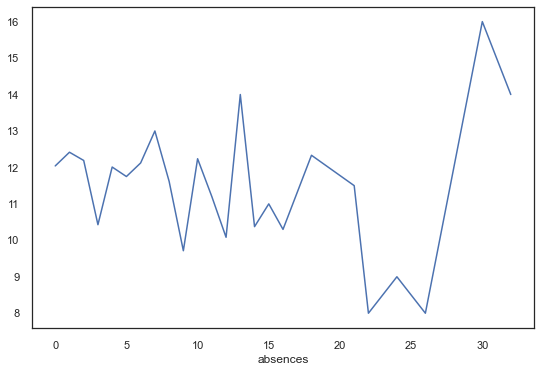

In [40]:
p.groupby('absences')['G3'].mean().plot()

In [43]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(p_feature)
poly2_columns = poly_2.get_feature_names(p_feature.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

(649, 629)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=9,test_size=0.2)

Medu  Fedu  traveltime  studytime  failures  schoolsup  famsup  \
223   4.0   3.0         2.0        3.0       0.0        0.0     1.0   
194   4.0   3.0         1.0        2.0       0.0        0.0     1.0   
426   3.0   3.0         2.0        1.0       0.0        0.0     1.0   
457   1.0   2.0         1.0        1.0       0.0        0.0     1.0   
6     2.0   2.0         1.0        2.0       0.0        0.0     0.0   
..    ...   ...         ...        ...       ...        ...     ...   
56    4.0   3.0         1.0        2.0       0.0        0.0     1.0   
501   4.0   3.0         1.0        1.0       0.0        0.0     0.0   
638   2.0   3.0         2.0        2.0       0.0        0.0     0.0   
348   4.0   2.0         2.0        3.0       0.0        0.0     1.0   
382   3.0   3.0         1.0        1.0       0.0        0.0     1.0   

     activities  nursery  higher  internet  romantic  famrel  freetime  goout  \
223         1.0      1.0     1.0       1.0       1.0     4.0       4.0    2.0   
194         1.0      1.0     1.0       1.0       0.0     3.0       4.0    3.0   
426         0.0      1.0     1.0       1.0       0.0     5.0       4.0    4.0   
457         1.0      1.0     1.0       1.0       0.0     5.0       5.0    5.0   
6           0.0      1.0     1.0       1.0       0.0     4.0       4.0    4.0   
..          ...      ...     ...       ...       ...     ...       ...    ...   
56          1.0      1.0     1.0       1.0       0.0     4.0       3.0    2.0   
501         1.0      1.0     1.0       1.0       0.0     4.0       2.0    5.0   
638         1.0      1.0     1.0       1.0       0.0     4.0       4.0    3.0   
348         0.0      1.0     1.0       1.0       0.0     4.0       3.0    3.0   
382         1.0      1.0     1.0       1.0       0.0     4.0       2.0    5.0   

     Dalc  Walc  health  absences  address_type_Urban  famsize_BIG_FAMILY  \
223   1.0   1.0     4.0       0.0                 0.0                 1.0   
194   2.0   3.0     3.0       4.0                 1.0                 1.0   
426   2.0   3.0     5.0       4.0                 0.0                 1.0   
457   5.0   5.0     3.0       4.0                 0.0                 0.0   
6     1.0   1.0     3.0       0.0                 1.0                 0.0   
..    ...   ...     ...       ...                 ...                 ...   
56    1.0   1.0     1.0       0.0                 1.0                 1.0   
501   1.0   5.0     5.0       8.0                 1.0                 0.0   
638   1.0   1.0     3.0       4.0                 1.0                 1.0   
348   1.0   1.0     3.0       0.0                 1.0                 1.0   
382   2.0   5.0     5.0       2.0                 1.0                 1.0   

     Pstatus_Together  Mjob_at_home  Mjob_health  Mjob_services  Mjob_teacher  \
223               1.0           0.0          0.0            0.0           1.0   
194               1.0           0.0          0.0            0.0           1.0   
426               1.0           1.0          0.0            0.0           0.0   
457               1.0           1.0          0.0            0.0           0.0   
6                 1.0           0.0          0.0            0.0           0.0   
..                ...           ...          ...            ...           ...   
56                0.0           0.0          0.0            1.0           0.0   
501               1.0           0.0          0.0            0.0           0.0   
638               1.0           0.0          0.0            0.0           0.0   
348               1.0           0.0          0.0            0.0           0.0   
382               1.0           1.0          0.0            0.0           0.0   

     Fjob_at_home  Fjob_health  Fjob_services  Fjob_teacher  reason_course  \
223           0.0          0.0            0.0           0.0            0.0   
194           0.0          0.0            0.0           0.0            0.0   
426           0.0          0.0            0.0  

In [45]:
scaler2 = StandardScaler()
# fit the scaler to the training data
scaler2.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=df_poly2.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=df_poly2.columns)

In [46]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 6.047495312220549e-14


In [47]:
# use fitted model to predict on test data
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 22.841785451080433
Training:  0 vs. Testing:  22


In [91]:
selector = SelectKBest(f_regression, k=80)

selector.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=80, score_func=<function f_regression at 0x7fa23c77e5e0>)

In [92]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [93]:
# list(selected_columns)
# len(removed_columns)

In [94]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)




Training Root Mean Squared Error: 2.5412271467951837
Testing Root Mean Squared Error: 2.7068067700259575
